#TP - iSeg2017

##Step 1: Chargement et affichage des données.

- Installation des librairies

In [ ]:
import sys

import sys
import tensorflow
import matplotlib
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import jupyter as jupyter
import os

print(f"Python Version: {sys.version}")
print(f"TensorFlow Version: {tensorflow.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"NiBabel Version: {nib.__version__}")

Python Version: 3.10.12 (main, Jun  7 2023, 12:45:35) [GCC 9.4.0]
TensorFlow Version: 2.12.0
Matplotlib Version: 3.7.1
NumPy Version: 1.22.4
NiBabel Version: 3.0.2


- Décompressez le fichier zip contenant les images médicales à l'aide de la bibliothèque zipfile.

In [ ]:
import zipfile

zip_path = '/content/iSeg-2017-Training.zip'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/images')

- Affichage d'images médicales.

In [ ]:
# Define the path to the image directory
image_dir = "/content/images/"

# Function to return the file path for a given image type and patient number
def get_image_path(patient_num, image_type):
    return f"{image_dir}subject-{patient_num}-{image_type}.img"

`displayImages` : Cette fonction affiche les images médicales pour 9 patients (indexés de 1 à 9) et pour trois types d'images différents : T1, T2 et label.

In [ ]:
def display_images():
  # Define the size of the grid for displaying the images.
  fig, axes = plt.subplots(nrows=9, ncols=9, figsize=(26, 16))

  # Loop over the 9 patients.
  for patient_num in range(1, 10):
      for i, image_type in enumerate(['T1', 'T2', 'label']):
          # Get the file path for the image.
          path_img = get_image_path(patient_num, image_type)

          # Load the image and extract the image data as a numpy array.
          img = nib.load(path_img)
          img_data = img.get_fdata().squeeze()

          # Calculate the coordinates for the center slice of the 3D image volume.
          x_med, y_med, z_med = np.array(img_data.shape) // 2

          axe_x = i + 2 * i;

          axes[patient_num - 1, axe_x].imshow(np.rot90(img_data[x_med, :, :]))
          axes[patient_num - 1, axe_x].set_title(f"P{patient_num} - {image_type}, X")
          axes[patient_num - 1, axe_x].set_axis_off()

          axes[patient_num - 1, axe_x + 1].imshow(np.rot90(img_data[:, y_med, :]))
          axes[patient_num - 1, axe_x + 1].set_title(f"P{patient_num} - {image_type}, Y")
          axes[patient_num - 1, axe_x + 1].set_axis_off()

          axes[patient_num - 1, axe_x + 2].imshow(img_data[:, :, z_med])
          axes[patient_num - 1, axe_x + 2].set_title(f"P{patient_num} - {image_type}, Z")
          axes[patient_num - 1, axe_x + 2].set_axis_off()
  # Show the figure
  plt.show()

In [ ]:
def display_images():
  # Loop over the 9 patients.
  for patient_num in range(1, 10):
      # Define the size of the grid for displaying the images.
      fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(6, 6))
      for i, image_type in enumerate(['T1', 'T2', 'label']):
          # Get the file path for the image.
          path_img = get_image_path(patient_num, image_type)

          # Load the image and extract the image data as a numpy array.
          img = nib.load(path_img)
          img_data = img.get_fdata().squeeze()

          # Calculate the coordinates for the center slice of the 3D image volume.
          x_med, y_med, z_med = np.array(img_data.shape) // 2

          axes[i, 0].imshow(np.rot90(img_data[x_med, :, :]))
          axes[i, 0].set_title(f"{image_type} - X")
          axes[i, 0].set_axis_off()

          axes[i, 1].imshow(np.rot90(img_data[:, y_med, :]))
          axes[i, 1].set_title(f"{image_type} - Y")
          axes[i, 1].set_axis_off()

          axes[i, 2].imshow(img_data[:, :, z_med])
          axes[i, 2].set_title(f"{image_type} - Z")
          axes[i, 2].set_axis_off()

          fig.suptitle(f"Patient {patient_num}")
  # Show the figure
      plt.show()

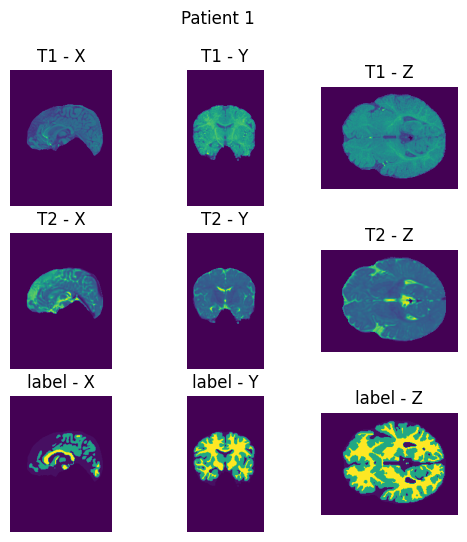

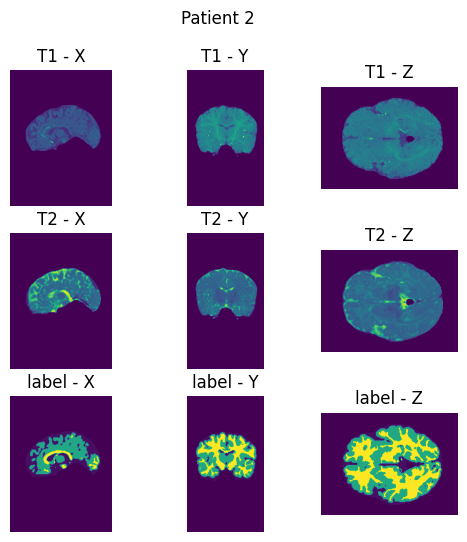

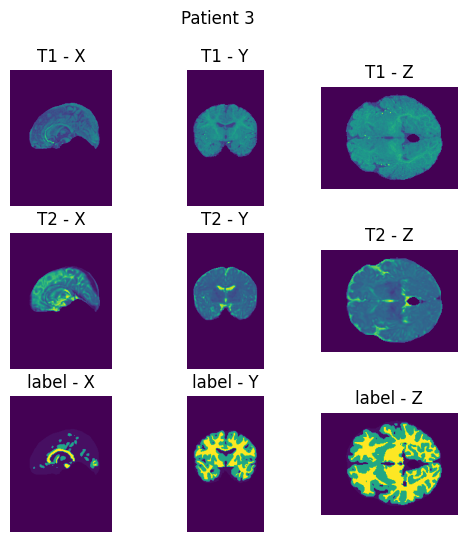

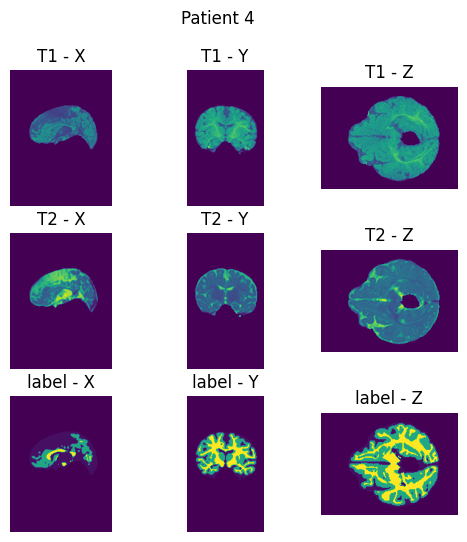

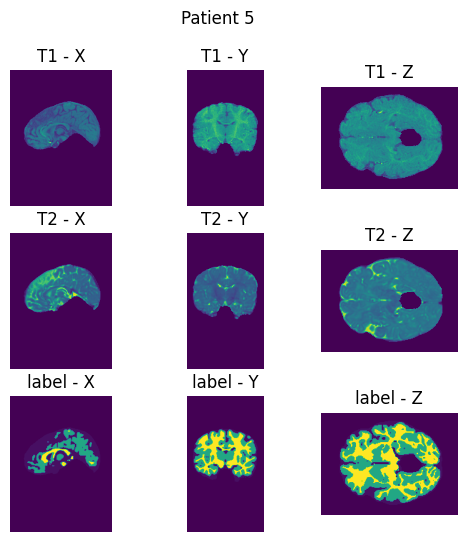

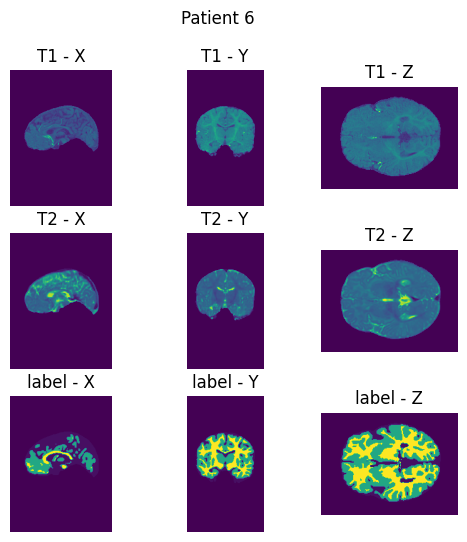

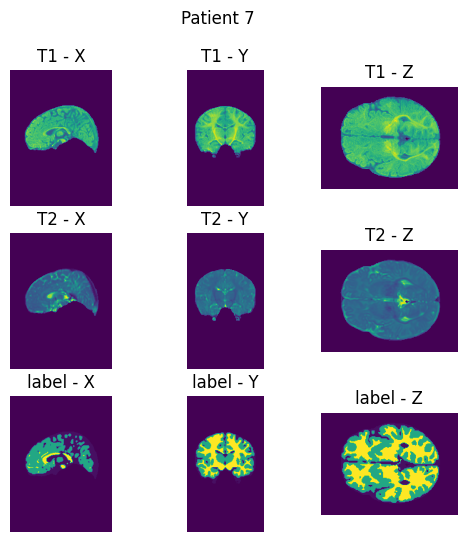

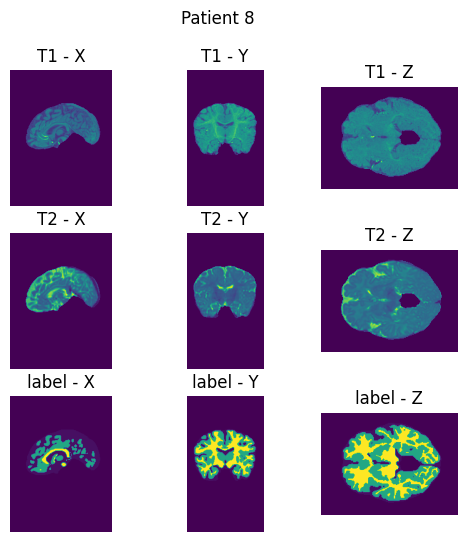

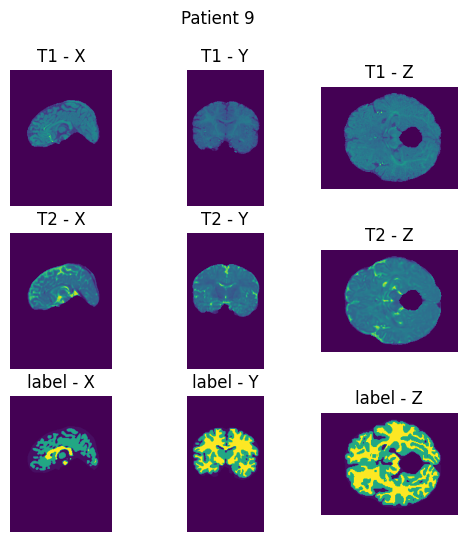

In [ ]:
display_images()

Pour repérer les zones d'intérêt en examinant la correspondance entre les images VT (Virtual Truth) et les images T1 et T2, il est important de comprendre que les images IRM sont généralement en niveaux de gris et n'ont pas de couleurs intrinsèques. Cependant, les visualisations peuvent utiliser des palettes de couleurs pour faciliter la distinction visuelle entre les différentes structures cérébrales.
Lors de l'observation des images T1, T2 et T_label, il est possible de remarquer des différences de contraste et de tonalité entre les différentes régions du cerveau. Ces différences peuvent être utilisées pour repérer les zones d'intérêt. Voici une description plus détaillée des caractéristiques visuelles des images T1, T2 et T_label :
1. **Images T1** :
Dans les images T1, les zones de substance grise apparaissent généralement plus sombres (de couleur bleu) que les zones de substance blanche (de couleur verte).
2. **Images T2** :
Dans les images T2, les zones de substance blanche apparaissent généralement plus sombres que les zones de substance grise. Il est possible d'observer une teinte bleue prédominante lors de la visualisation des images T2.
3. **Images T3** :
Les images label sont des étiquettes de segmentation qui identifient et délimitent différentes régions du cerveau. On y voit des couleurs tels que le jaune et le vert pour différencier les structures spécifiques dans les images de label. Ces couleurs facilitent la visualisation et l'interprétation des résultats de segmentation. La partie jaune fait référence à la zone blanche, et le vert à la zone grise.

## Step 2 : Normalisation des données

`normalize_image` : Cette fonction prend une image en entrée et la normalise à l'aide d'une technique de normalisation gaussienne. Il calcule la moyenne et l'écart type des valeurs positives de l'image, puis applique la formule de normalisation, qui soustrait la moyenne et divise par 5 fois l'écart type. L'image normalisée résultante est renvoyée en sortie.

In [ ]:
def normalize_image(img):
    # Compute mean and standard deviation of positive values in the image
    positive_vals = img[img > 0]
    mean = np.mean(positive_vals)
    std = np.std(positive_vals)

    # Normalize the image using a Gaussian normalization
    normalized_img = (img - mean) / (5 * std)

    return normalized_img

`slice_patients` : Fonction qui découpe une liste de patients en trois sous-listes : train_patients, valid_patients et test_patients

In [ ]:
def slice_patients(patients):
  train_patients = patients[:6]
  valid_patients = patients[6:8]
  test_patients = patients[8:]

  return train_patients, valid_patients, test_patients

`get_images` : La fonction permet de charger les images d'IRM pour les patients à partir des fichiers de données correspondants et les organise dans une structure de tableau numpy, puis renvoie ce tableau contenant toutes les images des patients.

In [ ]:
def get_images():
    images = []
    # Loop over the 9 patients.
    for patient_num in range(1, 11):
        imgs_patients = []
        for image_type in ['T1', 'T2', 'label']:
            # Get the file path for the image.
            path_img = get_image_path(patient_num, image_type)

            # Load the image and extract the image data as a numpy array.
            img = nib.load(path_img)
            img_data = img.get_fdata().squeeze()
            imgs_patients.append(img_data)
        images.append(imgs_patients)
    return np.array(images)

In [ ]:
images = get_images()
train_patients, valid_patients, test_patients = slice_patients(images)
print("Nombre de patients dans l'ensemble d'entraînement : ", len(train_patients))
print("Nombre de patients dans l'ensemble de validation : ", len(valid_patients))
print("Nombre de patients dans l'ensemble de test : ", len(test_patients))

Nombre de patients dans l'ensemble d'entraînement :  6
Nombre de patients dans l'ensemble de validation :  2
Nombre de patients dans l'ensemble de test :  2


`display_img_normalize` : Fonction qui affiche les images normaliser des patients







In [ ]:
def display_img_normalize(patients):
    fig, axes = plt.subplots(nrows=10, ncols=9, figsize=(26, 16))
    image_type = ['T1', 'T2', 'label']
    for patient_num, patient_imgs in enumerate(patients):
        for i, img_data in enumerate(patient_imgs):
            if (i == 0 or i == 1):
              img_data = normalize_image(img_data)

            x_med, y_med, z_med = np.array(img_data.shape) // 2
            axe_x = i + 2 * i;

            img_x = np.rot90(img_data[x_med, :, :])
            axes[patient_num, axe_x].imshow(img_x)
            axes[patient_num, axe_x].set_title(f"P{patient_num+1} - {image_type[i]}, X")
            axes[patient_num, axe_x].axis('off')

            img_y = np.rot90(img_data[:, y_med, :])
            axes[patient_num, axe_x + 1].imshow(img_y)
            axes[patient_num, axe_x + 1].set_title(f"P{patient_num+1} - {image_type[i]}, Y")
            axes[patient_num, axe_x + 1].axis('off')

            img_z = img_data[:, :, z_med]
            axes[patient_num, axe_x + 2].imshow(img_z)
            axes[patient_num, axe_x + 2].set_title(f"P{patient_num+1} - {image_type[i]}, Z")
            axes[patient_num, axe_x + 2].axis('off')
    # Show the figure
    plt.show()

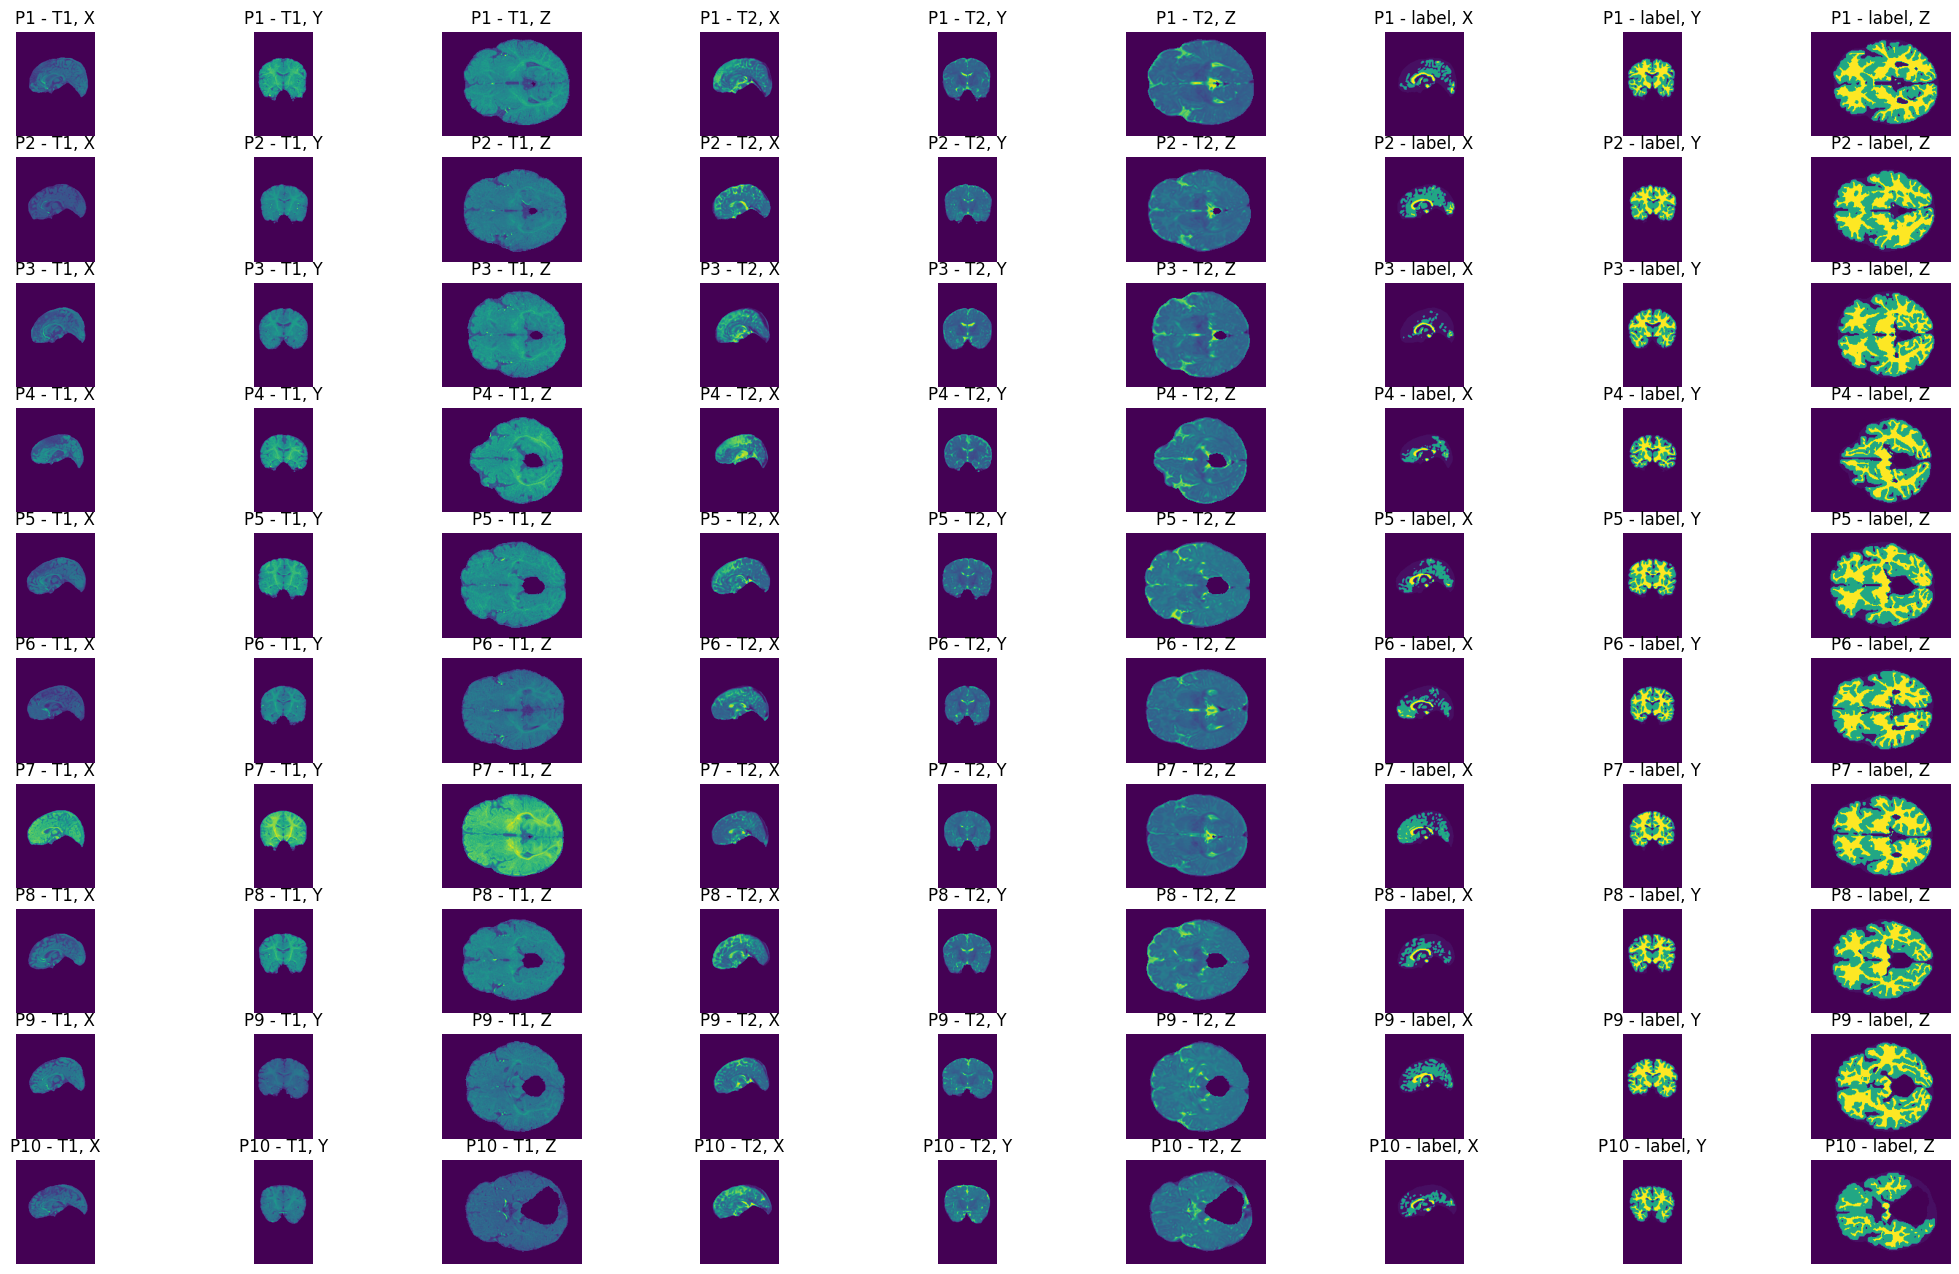

In [ ]:
display_img_normalize(images)

La normalisation des images médicales, telle que la VT (Virtual Truth), n'est généralement pas nécessaire car la VT est une image de référence utilisée pour évaluer les performances de modèles ou d'algorithmes de traitement d'images. La VT représente généralement la vérité terrain ou l'étiquetage manuel des régions d'intérêt dans les images T1 ou T2. Elle est déjà prédéfinie et n'a pas besoin d'être normalisée car elle ne représente pas les intensités de signal réelles des tissus cérébraux, mais plutôt les régions d'intérêt attendues.

##Step 3 - Formatage des données en mode 2D

###a) On sélectionne les coupes en z des patients d'entraînement ayant une aire de cerveau supérieure à 100 pour être utilisées par le réseau.

In [ ]:
train_patients.shape

(6, 3, 144, 192, 256)

`select_slice_z` : Fonction qui compte le nombre de coupes en z qui ont une quantité suffisante de tissu cérébral dans les images de la VT (Virtual Truth) des patients données

In [ ]:
def select_slice_z(patients):
  NBCOUPES = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              NBCOUPES += 1
  return NBCOUPES

In [ ]:
NBCOUPES = select_slice_z(train_patients)

###b) On a notre nombre NBCOUPES de coupes 2D pertinentes

In [ ]:
print("Nombre de coupes en z avec suffisamment de tissu cérébral:", NBCOUPES)

Nombre de coupes en z avec suffisamment de tissu cérébral: 599


###c) On crée via np.zeros une matrice XTRAIN de taille (NBCOUPES,SX,SY,2) (où le 2 vient du fait que l’on a 2 canaux: T1 et T2) et une YTRAIN de taille (NBCOUPES,SX,SY).

In [ ]:
SX = train_patients.shape[2]  # taille en x
SY = train_patients.shape[3]  # taille en y

XTRAIN = np.zeros((NBCOUPES, SX, SY, 2))
YTRAIN = np.zeros((NBCOUPES, SX, SY))

print("La taille de la matrice XTRAIN est de :", XTRAIN.shape)
print("La taille de la matrice YTRAIN est de :", YTRAIN.shape)

La taille de la matrice XTRAIN est de : (599, 144, 192, 2)
La taille de la matrice YTRAIN est de : (599, 144, 192)


###d) On stocke les versions normalisées des T1/T2

In [ ]:
def normalize_patients():
  normalize_train = []
  for patients in train_patients:
    normalize_train.append(normalize_image(patients[0]))
    normalize_train.append(normalize_image(patients[1]))
  return normalize_train

In [ ]:
normalize_train = normalize_patients()

###e) On reparcourt tous les patients (for numpatient ...) et toutes leurs coupes (for z ...) comme avant (utilisons un compteur NUM- COUPE), sauf que quand le critère d’aire est vérifié, on la stocke dans notre matrice XTRAIN les coupes T1 et T2 normalisées, et en parallèle on stocke la VT correspondante dans YTRAIN.

In [ ]:
def forward(patients, XMATRICE, YMATRICE):
  NUMCOUPE = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              T1 = normalize_image(patient_data[0][:,:,z_slice])
              T2 = normalize_image(patient_data[1][:,:,z_slice])
              mask = img_vt[:,:,z_slice]

              # Ajout de la condition pour remplir YTRAIN avec des 1
              mask = np.where((mask == 10) | (mask == 150) | (mask == 250), 1, 0)

              XMATRICE[NUMCOUPE,:,:,0] = T1
              XMATRICE[NUMCOUPE,:,:,1] = T2
              YMATRICE[NUMCOUPE,:,:] = mask
              NUMCOUPE += 1

In [ ]:
forward(train_patients, XTRAIN, YTRAIN)
print(XTRAIN.shape)

(599, 144, 192, 2)


In [ ]:
def display_XTRAIN(i):
  # Séparation des deux canaux de couleur
  T1 = XTRAIN[i, :, :, 0]
  T2 = XTRAIN[i, :, :, 1]

  # Affichage des deux images
  fig, ax = plt.subplots(1, 2)
  ax[0].imshow(T1)
  ax[1].imshow(T2)
  plt.show()

In [ ]:
def display_YTRAIN(i):
  # Séparation des deux canaux de couleur
  plt.imshow(YTRAIN[i,:,:])
  plt.show()

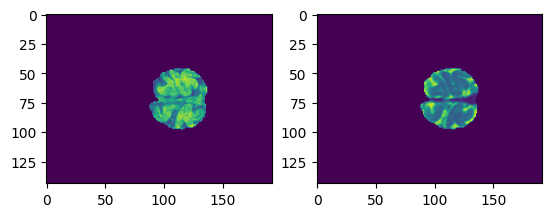

In [ ]:
display_XTRAIN(300)

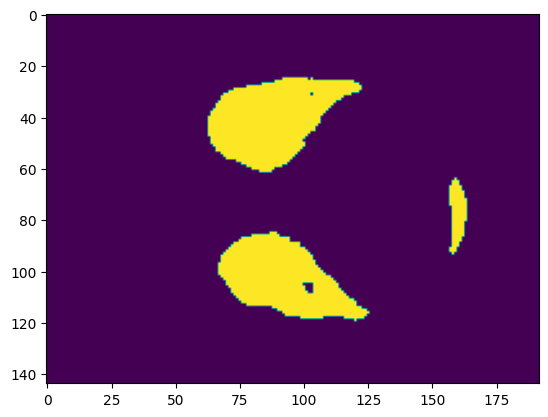

In [ ]:
display_YTRAIN(10)

###f) On recommence toute la procédure pour les données de validation

In [ ]:
SX = valid_patients.shape[2]  # taille en x
SY = valid_patients.shape[3]  # taille en y

XVAL = np.zeros((NBCOUPES, SX, SY, 2))
YVAL = np.zeros((NBCOUPES, SX, SY))

NBCOUPES = select_slice_z(valid_patients)
print("Nombre de coupes en z avec suffisamment de tissu cérébral:", NBCOUPES)

Nombre de coupes en z avec suffisamment de tissu cérébral: 199


In [ ]:
forward(valid_patients, XVAL, YVAL)

## Step 4 : un premier entraînement de réseau !

-  chargez la bibliothèque TF (import tensorflow)

In [ ]:
import tensorflow as tf

- allez télécharger le code du U-Net sur l’URL donnée dans l’énonce (l’autre fichier).

In [ ]:
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

- greffez le dans votre notebook et créez une modele de réseau de neurones ayant cette architecture.

In [ ]:
model = unet(input_size = (144,192,2))
model

- compilez le avec les bons paramètres saisis en amont (l’optimiser Adam, le learning rate) (voir model.compile)
→ on verra plus tard ce qui est checkpoint, earlystopping, et Re- duceLROnPlateau.

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

- utilisez model.fit sur vos inputs et outputs préparées en amont, et observez le loss de training et le loss de validation descendent au moins
au début de votre entrainement (sinon appelez-moi).
→ attention: rentre bien en parametre XTRAIN, YTRAIN, XVAL,YVAL (googlez pour voir la syntaxe exacte de tensorflow).

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Définit les callbacks
checkpoint = ModelCheckpoint('model.h5', save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=5)

# Entraîne le modèle
#history = model.fit(x=XTRAIN, y=YTRAIN, validation_data=(XVAL, YVAL), epochs=50, batch_size=32, callbacks=[checkpoint, earlystop])
history = model.fit(x=XTRAIN, y=YTRAIN, validation_data=(XVAL, YVAL), epochs=30, batch_size=32)


Epoch 1/30
19/19 [==============================] - 23s 1s/step - loss: 0.2050 - accuracy: 0.9965 - val_loss: 0.5610 - val_accuracy: 0.4490
Epoch 2/30
19/19 [==============================] - 23s 1s/step - loss: 0.2049 - accuracy: 0.9962 - val_loss: 0.5559 - val_accuracy: 0.4404
Epoch 3/30
19/19 [==============================] - 23s 1s/step - loss: 0.2039 - accuracy: 0.9968 - val_loss: 0.5549 - val_accuracy: 0.4382
Epoch 4/30
19/19 [==============================] - 23s 1s/step - loss: 0.2033 - accuracy: 0.9971 - val_loss: 0.5587 - val_accuracy: 0.4407
Epoch 5/30
19/19 [==============================] - 23s 1s/step - loss: 0.2027 - accuracy: 0.9972 - val_loss: 0.5567 - val_accuracy: 0.4460
Epoch 6/30
19/19 [==============================] - 23s 1s/step - loss: 0.2021 - accuracy: 0.9975 - val_loss: 0.5567 - val_accuracy: 0.4480
Epoch 7/30
19/19 [==============================] - 23s 1s/step - loss: 0.2017 - accuracy: 0.9976 - val_loss: 0.5533 - val_accuracy: 0.4405
Epoch 8/30
19/19 [==

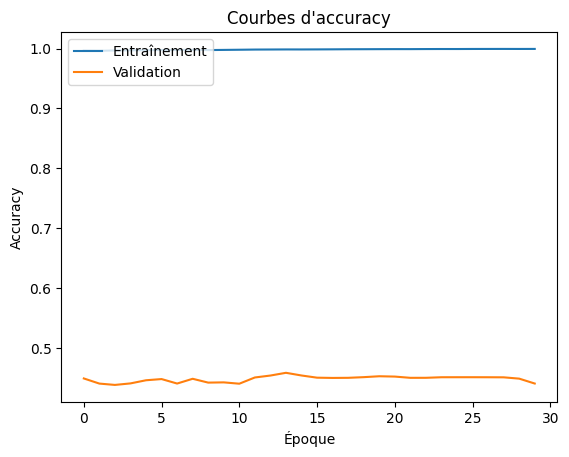

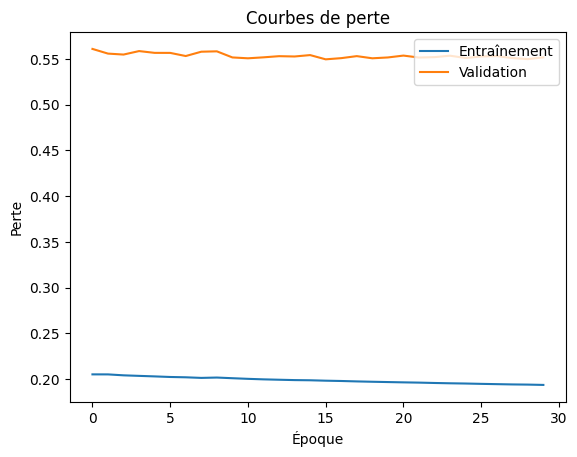

In [ ]:
# Afficher les courbes d'accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Courbes d\'accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Afficher les courbes de perte
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Courbes de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

##Step 5 : Finir la première étape de la cascade

`evaluate_network` : La fonction evaluate_network effectue la prédiction du modèle sur les images de test

In [ ]:
PREDICTION_TRAIN = []
PREDICTION_VAL = []

def evaluate_network(all_predictions):
    dices = []
    for i, patient in enumerate(test_patients):
        # normalize T1 and T2 test data
        T1NORM = normalize_image(patient[0])
        T2NORM = normalize_image(patient[1])

        # create empty prediction array
        PREDICTION = np.zeros(patient[0].shape)

        # loop over each slice in z direction
        for z in range(patient[0].shape[2]):
            # extract normalized T1 and T2 slices
            t1_slice = T1NORM[:,:,z]
            t2_slice = T2NORM[:,:,z]

            # create input array of shape (1, sx, sy, 2)
            input_array = np.zeros((1,) + t1_slice.shape + (2,))
            #print(input_array.shape)
            input_array[0,:,:,0] = t1_slice
            input_array[0,:,:,1] = t2_slice

            # make prediction on input array
            prediction = model.predict(input_array, verbose = 0)

            # threshold prediction to get binary output
            output_final = np.where(prediction > 0.5, 1, 0)

            # store binary output in prediction array
            #print(output_final.shape)
            PREDICTION[:,:,z] = np.squeeze(output_final)
        all_predictions.append(PREDICTION)

        # calculate dice score for patient
        truth = patient[2]
        truth = np.where((truth == 10) | (truth == 150) | (truth == 250), 1, 0)
        dice = 2 * np.sum(PREDICTION * truth) / (np.sum(PREDICTION) + np.sum(truth))
        dices.append(dice)
    return dices


In [ ]:
evaluate_network(PREDICTION_TRAIN)

[0.9731262958971112, 0.9698654760444251]

##Step 6 : Programmation de l’étage 2 de la cascade:

Les listes `PREDICTION_TRAIN` et `PREDICTION_VAL` sont créées pour regrouper les T1 normalisées avec les T2 normalisées et les prédictions binarisées du réseau neuronal précédent sur les données d'entraînement (TRAIN) et de validation (VALIDATION).

In [ ]:
model2 = unet(input_size = (144,192,3))
model2

In [ ]:
def forward2(patients, XMATRICE, YMATRICE):
  NUMCOUPE = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          VT10 = np.where(img_vt >= 10, 1, 0)
          VT150 = np.where(img_vt >= 150, 1, 0)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              T1 = normalize_image(patient_data[0][:,:,z_slice])
              T2 = normalize_image(patient_data[1][:,:,z_slice])
              mask = img_vt[:,:,z_slice]

              XMATRICE[NUMCOUPE,:,:,0] = T1
              XMATRICE[NUMCOUPE,:,:,1] = T2
              XMATRICE[NUMCOUPE,:,:,2] = VT10[:,:,z_slice]
              YMATRICE[NUMCOUPE,:,:] = VT150[:,:,z_slice]
              NUMCOUPE += 1

In [ ]:
NBCOUPES = select_slice_z(train_patients)

XTRAIN2 = np.zeros((NBCOUPES, SX, SY, 3))
YTRAIN2 = np.zeros((NBCOUPES, SX, SY))

NBCOUPES = select_slice_z(valid_patients)

XVAL2 = np.zeros((NBCOUPES, SX, SY, 3))
YVAL2 = np.zeros((NBCOUPES, SX, SY))

forward2(train_patients, XTRAIN2, YTRAIN2)
forward2(valid_patients, XVAL2, YVAL2)

In [ ]:
def fast_display(T1, T2, prediction, VT):
    # Création d'une figure avec 1 ligne et 4 colonnes
    fig, axs = plt.subplots(1, 4, figsize=(20,5))

    # Affichage de la première image T1
    axs[0].imshow(T1)
    axs[0].set_title('T1')

    # Affichage de la deuxième image T2
    axs[1].imshow(T2)
    axs[1].set_title('T2')

    # Affichage de la troisième image prediction
    axs[2].imshow(prediction)
    axs[2].set_title('Prediction')

    # Affichage de la quatrième image VT
    axs[3].imshow(VT)
    axs[3].set_title('VT')

    # Suppression des axes pour une meilleure présentation
    for ax in axs:
        ax.axis('off')

    # Affichage de la figure
    plt.show()


In [ ]:
def evaluate_network_step_2(patients):
  lst_dice = np.zeros(patients.shape)
  dices = []
  NUMCOUPE = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      prediction3D_150 = np.zeros(patient_data[0].shape)
      T1NORM = normalize_image(patient_data[0])
      T2NORM = normalize_image(patient_data[1])
      VT10 = np.where(patient_data[2] >= 10, 1, 0)
      VT150 = np.where(patient_data[2] >= 150, 1, 0)

      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              t1_slice = T1NORM[:,:,z_slice]
              t2_slice = T2NORM[:,:,z_slice]

              input_array1 = np.zeros((1,) + t1_slice.shape + (2,))
              input_array1[0,:,:,0] = t1_slice
              input_array1[0,:,:,1] = t2_slice
              prediction10 = np.round(model.predict(input_array1, verbose=0)).squeeze()

              input_array2 = np.zeros((1,) + t1_slice.shape + (3,))
              input_array2[0,:,:,0] = t1_slice
              input_array2[0,:,:,1] = t2_slice
              input_array2[0,:,:,2] = prediction10
              prediction150 = np.round(model2.predict(input_array2, verbose=0)).squeeze()

              prediction3D_150[:,:,z_slice] = np.copy(prediction150)

              #Pour afficher
              predict_to_plot = np.copy(prediction150)
              VT_to_plot = np.copy(VT150[:,:,z_slice])
              if (z_slice % 10 == 0 and np.sum(VT_to_plot) > 0):
                VT_to_plot[0,0] = 1.0
                predict_to_plot[0,0] = 1.0
                fast_display(T1NORM[:,:,z_slice].squeeze(), T2NORM[:,:,z_slice].squeeze(), prediction3D_150[:,:,z_slice], VT_to_plot)
      dice = 2 * np.sum(prediction3D_150 * VT150) / (np.sum(prediction3D_150) + np.sum(VT150))
      dices.append(dice)
  return dices

In [ ]:
history2 = model2.fit(x=XTRAIN2,y=YTRAIN2, validation_data=(XVAL2, YVAL2), batch_size=32, epochs=30)

Epoch 1/30
19/19 [==============================] - 20s 1s/step - loss: 0.1614 - accuracy: 0.9897 - val_loss: 0.1867 - val_accuracy: 0.9769
Epoch 2/30
19/19 [==============================] - 19s 1s/step - loss: 0.1615 - accuracy: 0.9894 - val_loss: 0.1873 - val_accuracy: 0.9781
Epoch 3/30
19/19 [==============================] - 19s 1s/step - loss: 0.1612 - accuracy: 0.9895 - val_loss: 0.1822 - val_accuracy: 0.9794
Epoch 4/30
19/19 [==============================] - 19s 1s/step - loss: 0.1606 - accuracy: 0.9899 - val_loss: 0.1844 - val_accuracy: 0.9794
Epoch 5/30
19/19 [==============================] - 20s 1s/step - loss: 0.1606 - accuracy: 0.9897 - val_loss: 0.1743 - val_accuracy: 0.9828
Epoch 6/30
19/19 [==============================] - 20s 1s/step - loss: 0.1603 - accuracy: 0.9897 - val_loss: 0.1815 - val_accuracy: 0.9787
Epoch 7/30
19/19 [==============================] - 20s 1s/step - loss: 0.1601 - accuracy: 0.9898 - val_loss: 0.1921 - val_accuracy: 0.9760
Epoch 8/30
19/19 [==

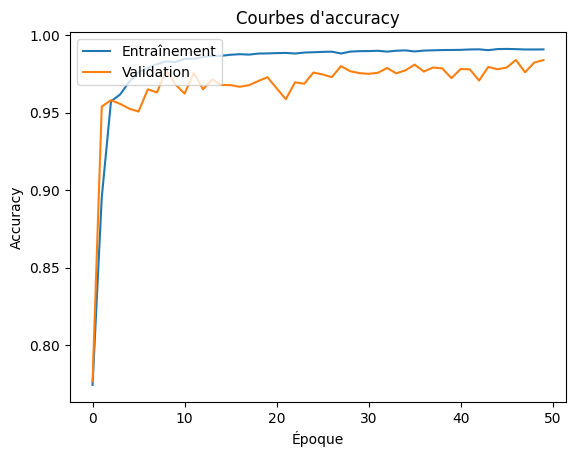

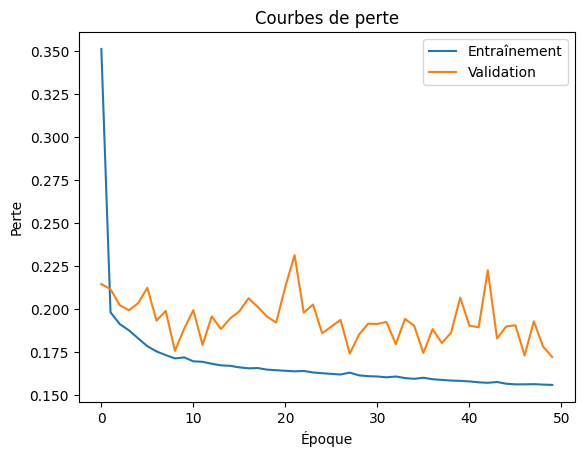

In [ ]:
# Afficher les courbes d'accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Courbes d\'accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Afficher les courbes de perte
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Courbes de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

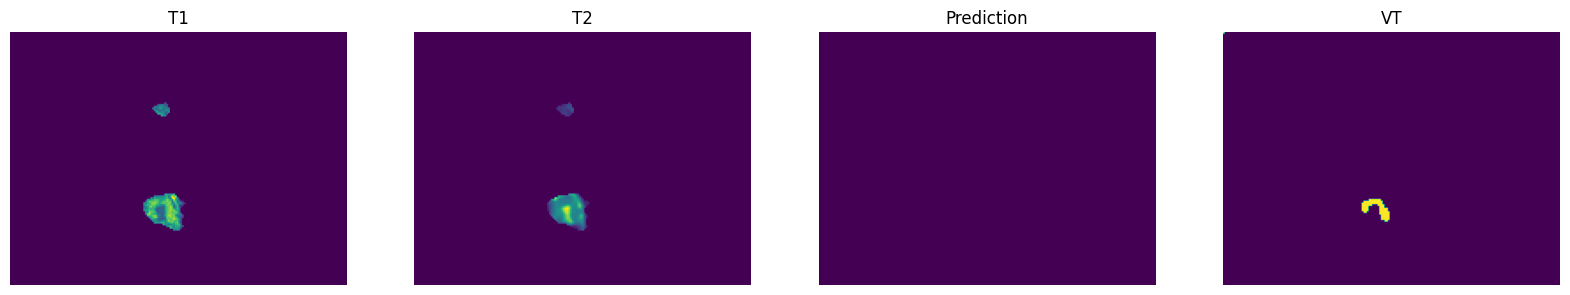

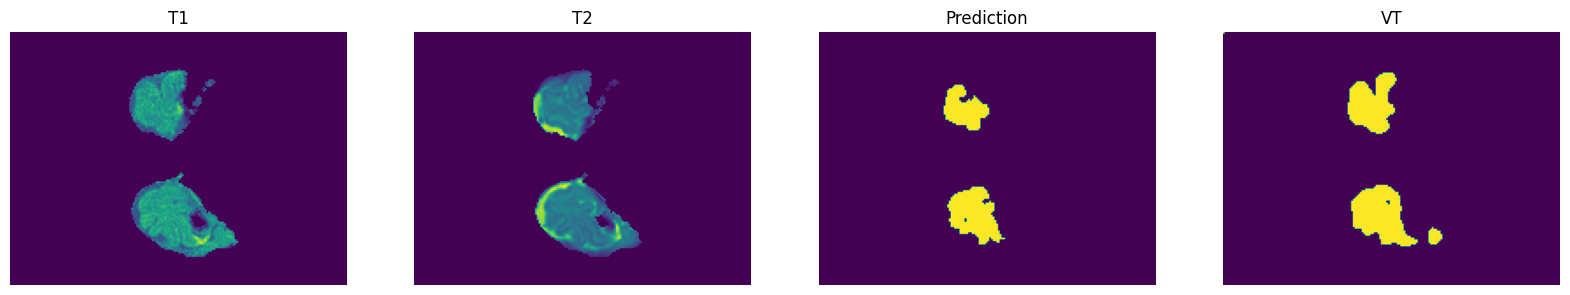

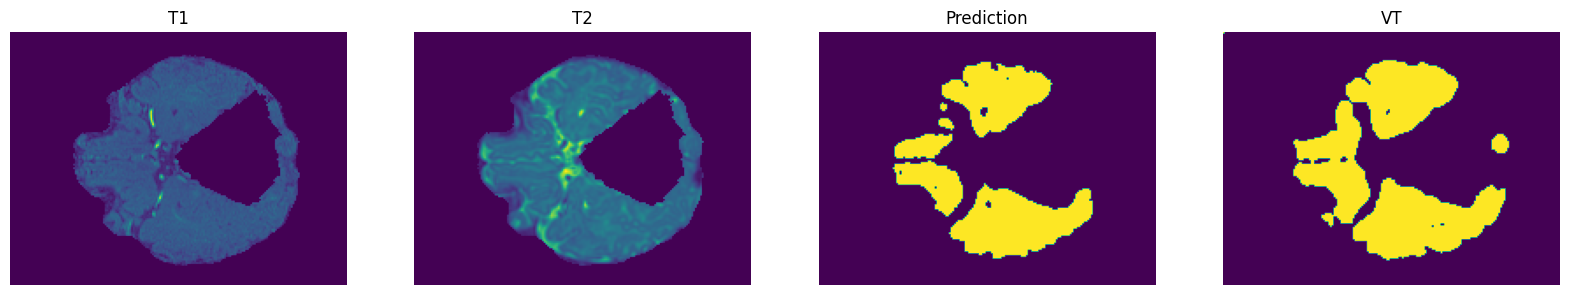

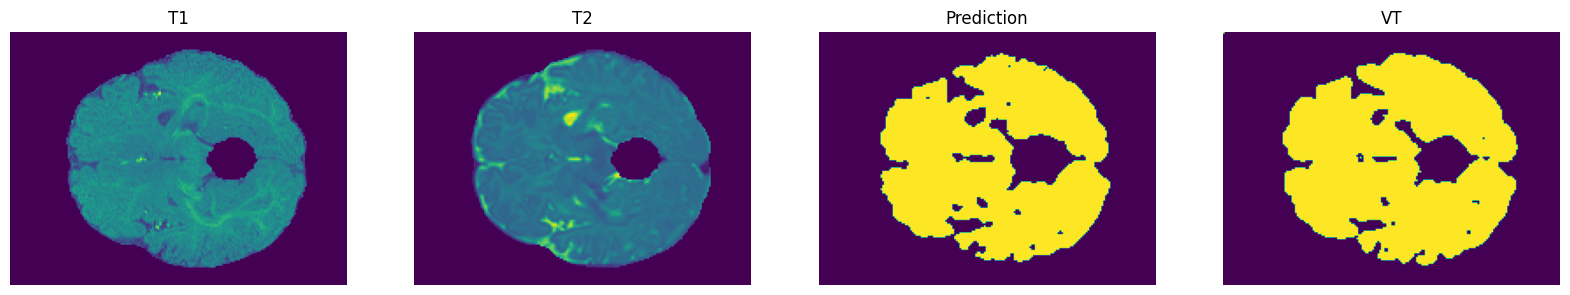

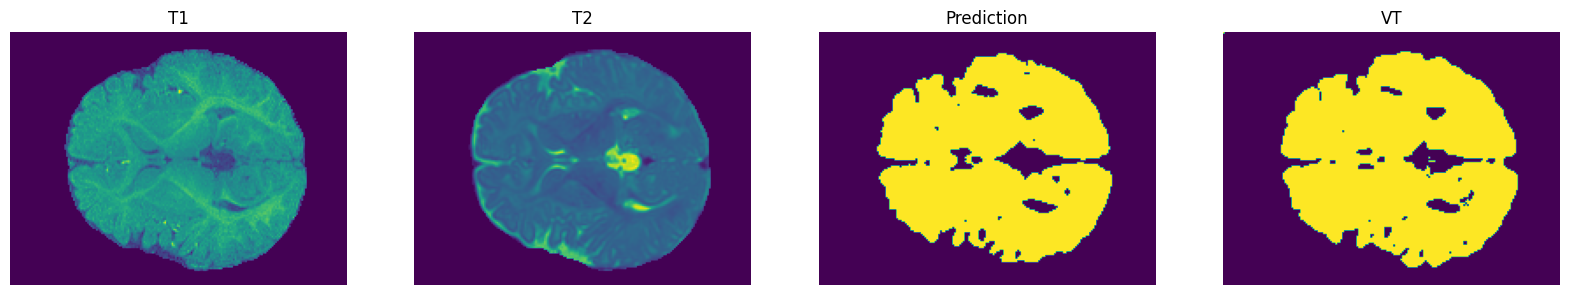

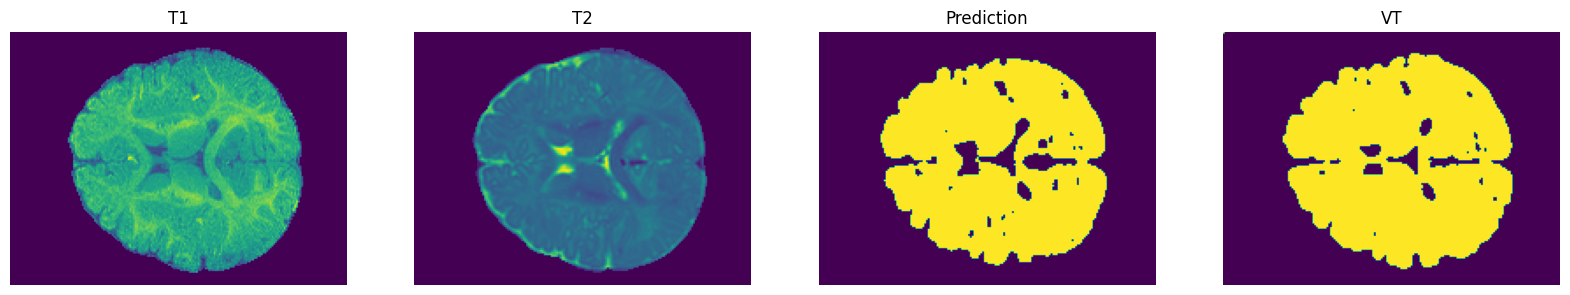

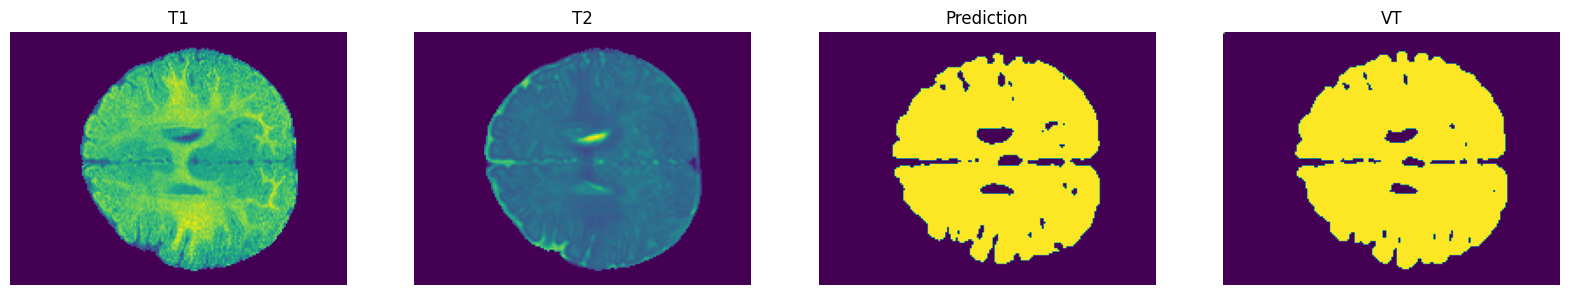

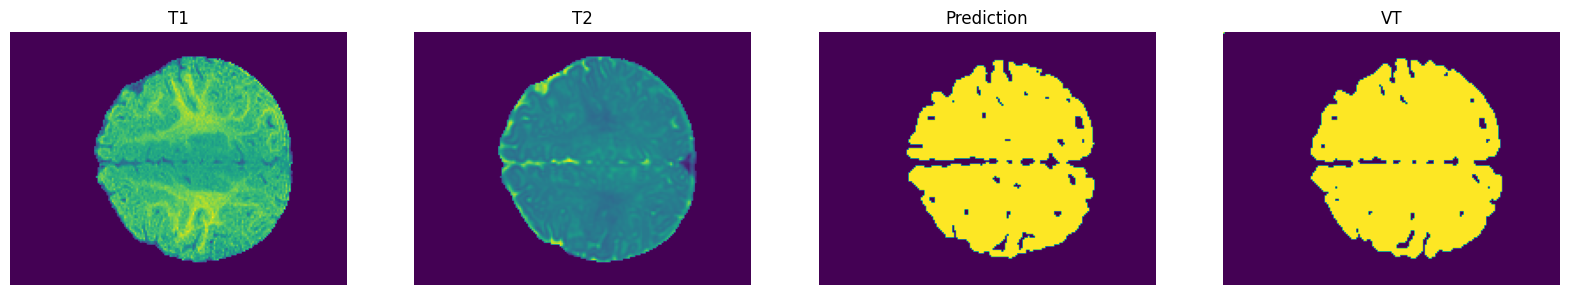

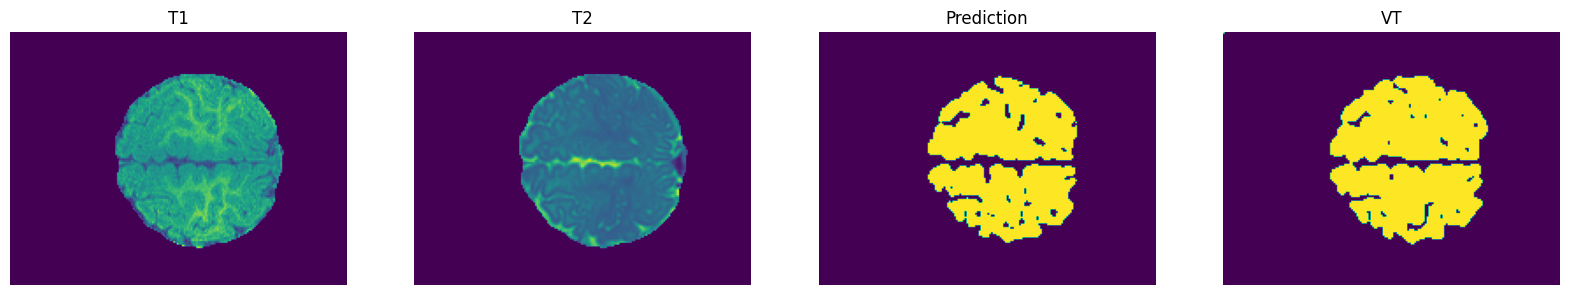

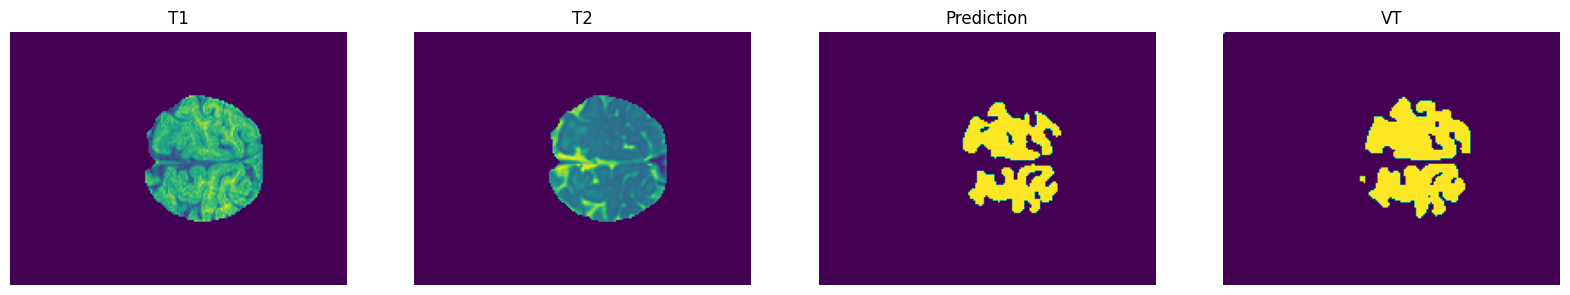

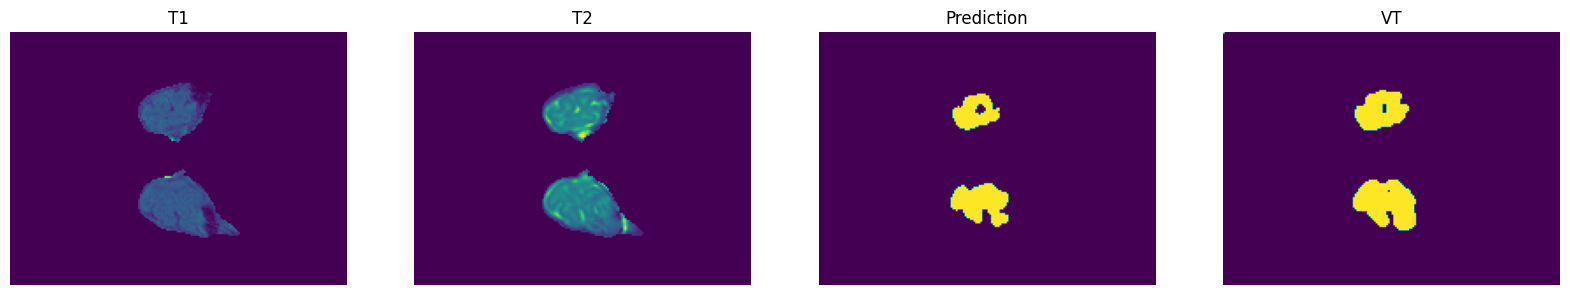

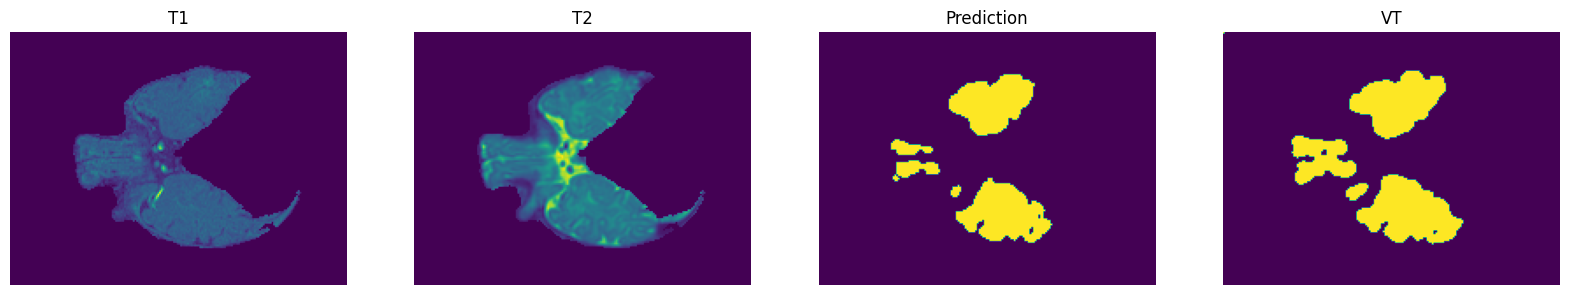

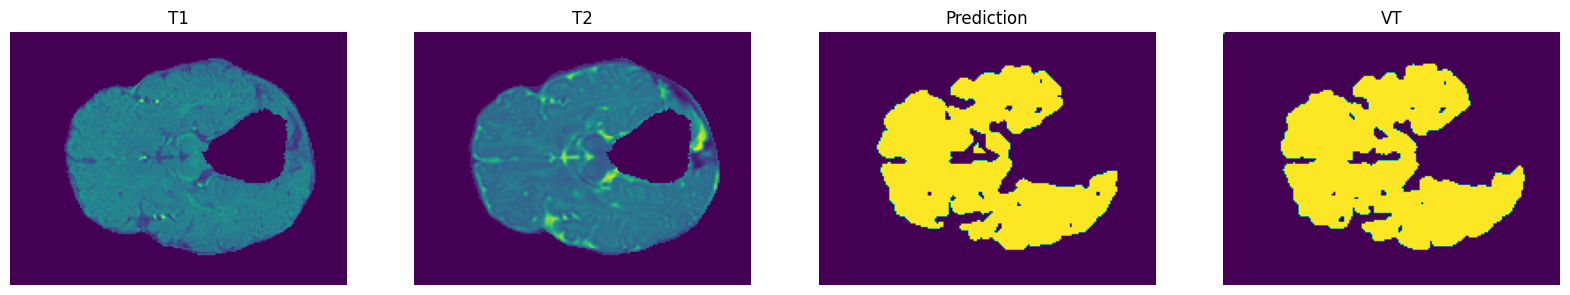

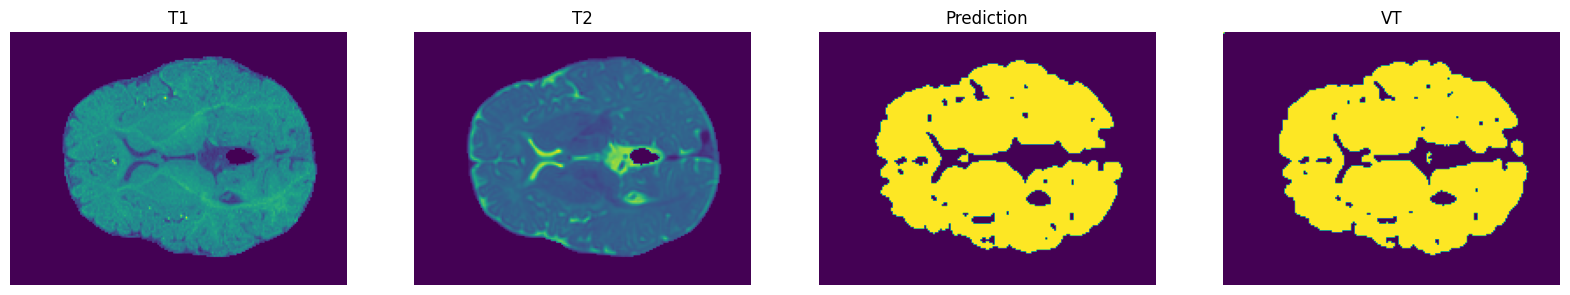

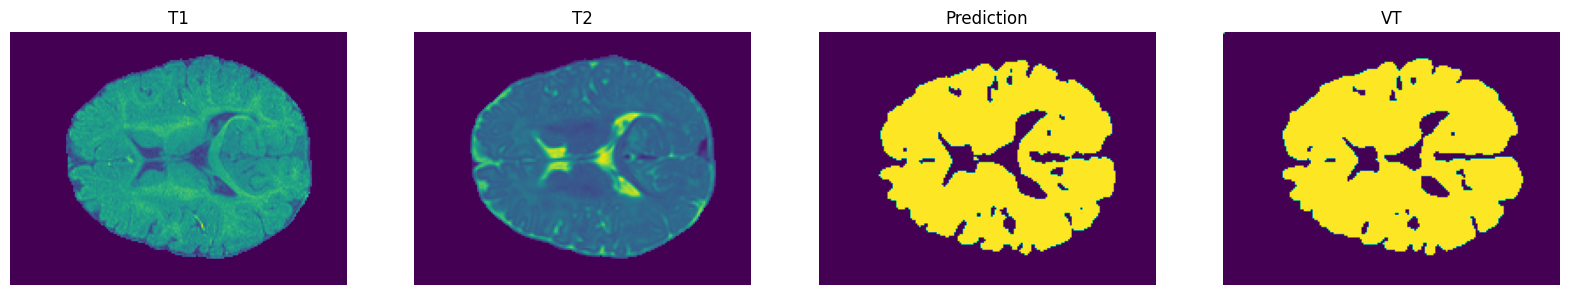

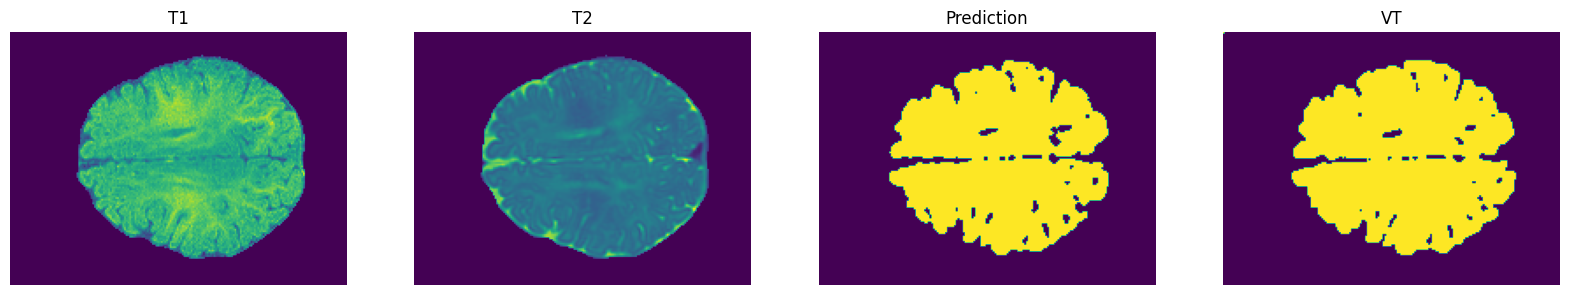

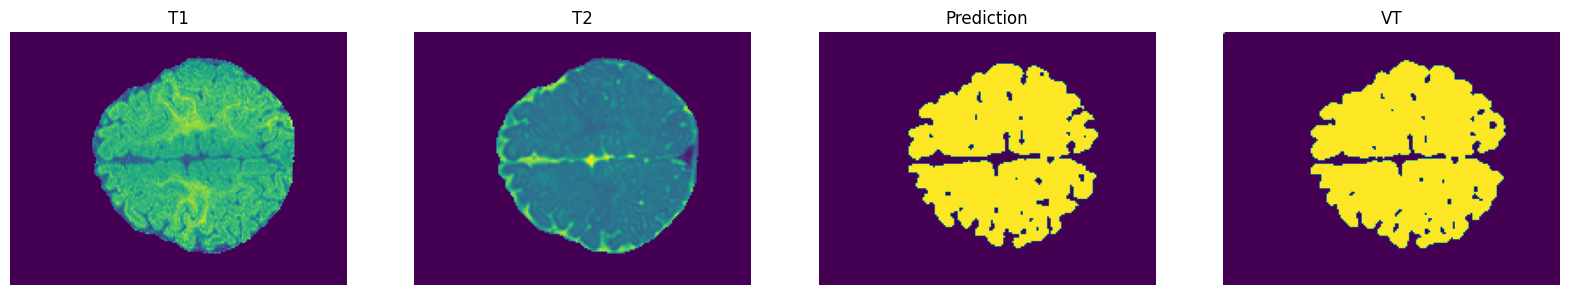

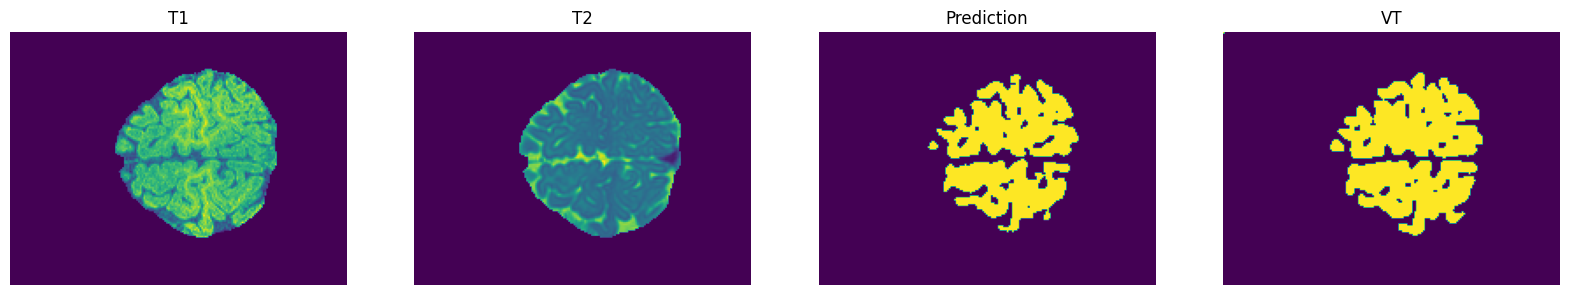

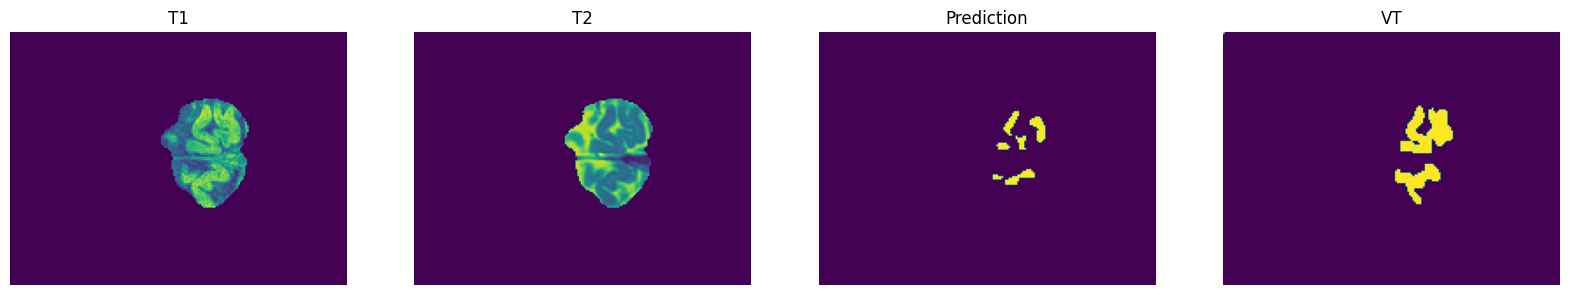

[0.9487457125512787, 0.9487149560406093]

In [ ]:
evaluate_network_step_2(test_patients)

##Step 7 : Programmation de l’étage 3 de la cascade et regroupement en données finales :

In [ ]:
def forward_step3(patients, XMATRICE, YMATRICE):
  NUMCOUPE = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          VT10 = np.where(img_vt >= 10, 1, 0)
          VT150 = np.where(img_vt >= 150, 1, 0)
          VT250 = np.where(img_vt >= 250, 1, 0)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              T1 = normalize_image(patient_data[0][:,:,z_slice])
              T2 = normalize_image(patient_data[1][:,:,z_slice])

              XMATRICE[NUMCOUPE,:,:,0] = T1
              XMATRICE[NUMCOUPE,:,:,1] = T2
              XMATRICE[NUMCOUPE,:,:,2] = VT10[:,:,z_slice]
              XMATRICE[NUMCOUPE,:,:,3] = VT150[:,:,z_slice]
              YMATRICE[NUMCOUPE,:,:] = VT250[:,:,z_slice]
              NUMCOUPE += 1

In [ ]:
NBCOUPES = select_slice_z(train_patients)

XTRAIN3 = np.zeros((NBCOUPES, SX, SY, 4))
YTRAIN3 = np.zeros((NBCOUPES, SX, SY))

NBCOUPES = select_slice_z(valid_patients)

XVAL3 = np.zeros((NBCOUPES, SX, SY, 4))
YVAL3 = np.zeros((NBCOUPES, SX, SY))

forward_step3(train_patients, XTRAIN3, YTRAIN3)
forward_step3(valid_patients, XVAL3, YVAL3)

In [ ]:
def evaluate_network_step_3(patients):
  dices = []
  lst_dice = np.zeros(patients.shape)
  NUMCOUPE = 0
  for patient_data in patients:
      img_vt = patient_data[2]
      prediction3D_250 = np.zeros(patient_data[0].shape)
      T1NORM = normalize_image(patient_data[0])
      T2NORM = normalize_image(patient_data[1])
      VT10 = np.where(patient_data[2] >= 10, 1, 0)
      VT150 = np.where(patient_data[2] >= 150, 1, 0)
      VT250 = np.where(patient_data[2] >= 250, 1, 0)

      prediction_final = np.zeros(patient_data[0].shape)

      for z_slice in range(img_vt.shape[2]):
          # Calcul de l'aire de tissu cérébral pour la coupe en z courante
          vt_mask = np.where(img_vt[:, :, z_slice] > 0, 1, 0)  # seuillage binaire avec VT
          brain_tissue_area = np.sum(vt_mask)

          # Vérification si l'aire de tissu cérébral est suffisante pour cette coupe en z
          if brain_tissue_area > 100:
              t1_slice = T1NORM[:,:,z_slice]
              t2_slice = T2NORM[:,:,z_slice]

              input_array1 = np.zeros((1,) + t1_slice.shape + (2,))
              input_array1[0,:,:,0] = t1_slice
              input_array1[0,:,:,1] = t2_slice
              prediction10 = np.round(model.predict(input_array1, verbose = 0)).squeeze()

              input_array2 = np.zeros((1,) + t1_slice.shape + (3,))
              input_array2[0,:,:,0] = t1_slice
              input_array2[0,:,:,1] = t2_slice
              input_array2[0,:,:,2] = prediction10
              prediction150 = np.round(model2.predict(input_array2, verbose = 0)).squeeze()

              input_array3 = np.zeros((1,) + t1_slice.shape + (4,))
              input_array3[0,:,:,0] = t1_slice
              input_array3[0,:,:,1] = t2_slice
              input_array3[0,:,:,2] = prediction10
              input_array3[0,:,:,3] = prediction150
              prediction250 = np.round(model3.predict(input_array3, verbose = 0)).squeeze()

              prediction = 10 * prediction10 + 140 * prediction150 + 100 * prediction250
              prediction_final[:,:,z_slice] = np.copy(prediction)

              prediction3D_250[:,:,z_slice] = np.copy(prediction250)
              #Pour afficher
              predict_to_plot = np.copy(prediction_final[:,:,z_slice])
              VT_to_plot = np.copy(img_vt[:,:,z_slice])
              if (z_slice % 10 == 0 and np.sum(VT_to_plot) > 0):
                VT_to_plot[0,0] = 1.0
                predict_to_plot[0,0] = 1.0
                fast_display(T1NORM[:,:,z_slice].squeeze(), T2NORM[:,:,z_slice].squeeze(), predict_to_plot, VT_to_plot)
      dice = 2 * np.sum(prediction3D_250 * VT250) / (np.sum(prediction3D_250) + np.sum(VT250))
      dices.append(dice)
  return dices

In [ ]:
model3 = unet(input_size = (144,192,4))
model3

In [ ]:
history3 = model3.fit(x=XTRAIN3,y=YTRAIN3, validation_data=(XVAL3, YVAL3), batch_size=30, epochs=20)

Epoch 1/20
20/20 [==============================] - 20s 1s/step - loss: 0.0847 - accuracy: 0.9773 - val_loss: 0.0979 - val_accuracy: 0.9696
Epoch 2/20
20/20 [==============================] - 19s 960ms/step - loss: 0.0827 - accuracy: 0.9789 - val_loss: 0.0963 - val_accuracy: 0.9701
Epoch 3/20
20/20 [==============================] - 20s 1s/step - loss: 0.0815 - accuracy: 0.9798 - val_loss: 0.0961 - val_accuracy: 0.9702
Epoch 4/20
20/20 [==============================] - 20s 1s/step - loss: 0.0815 - accuracy: 0.9797 - val_loss: 0.0967 - val_accuracy: 0.9702
Epoch 5/20
20/20 [==============================] - 21s 1s/step - loss: 0.0808 - accuracy: 0.9802 - val_loss: 0.0958 - val_accuracy: 0.9705
Epoch 6/20
20/20 [==============================] - 21s 1s/step - loss: 0.0803 - accuracy: 0.9805 - val_loss: 0.0946 - val_accuracy: 0.9706
Epoch 7/20
20/20 [==============================] - 21s 1s/step - loss: 0.0802 - accuracy: 0.9806 - val_loss: 0.1001 - val_accuracy: 0.9700
Epoch 8/20
20/20 

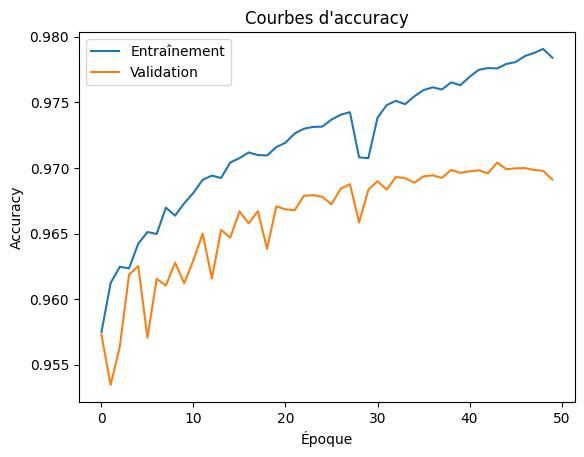

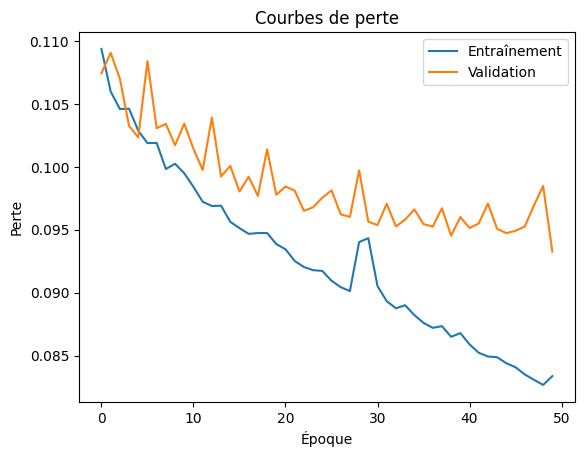

In [ ]:
# Afficher les courbes d'accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Courbes d\'accuracy')
plt.xlabel('Époque')
plt.ylabel('Accuracy')
plt.legend(['Entraînement', 'Validation'], loc='upper left')
plt.show()

# Afficher les courbes de perte
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Courbes de perte')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend(['Entraînement', 'Validation'], loc='upper right')
plt.show()

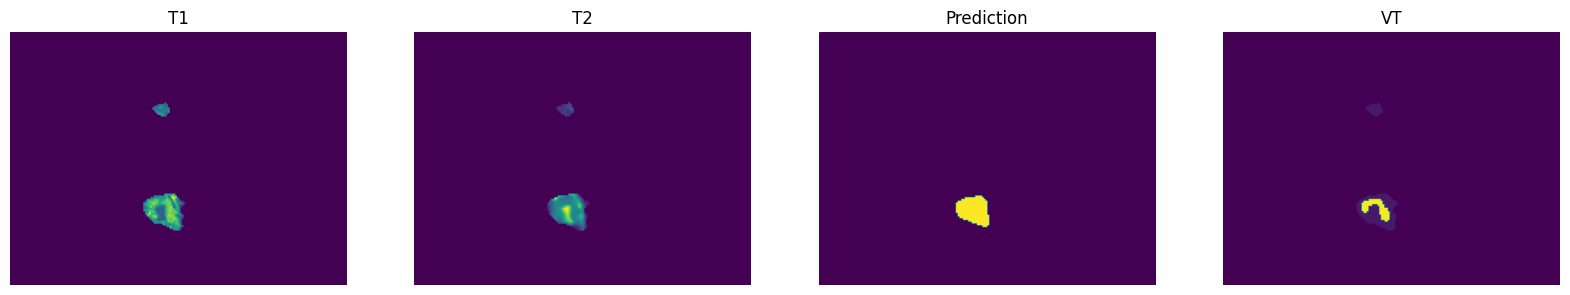

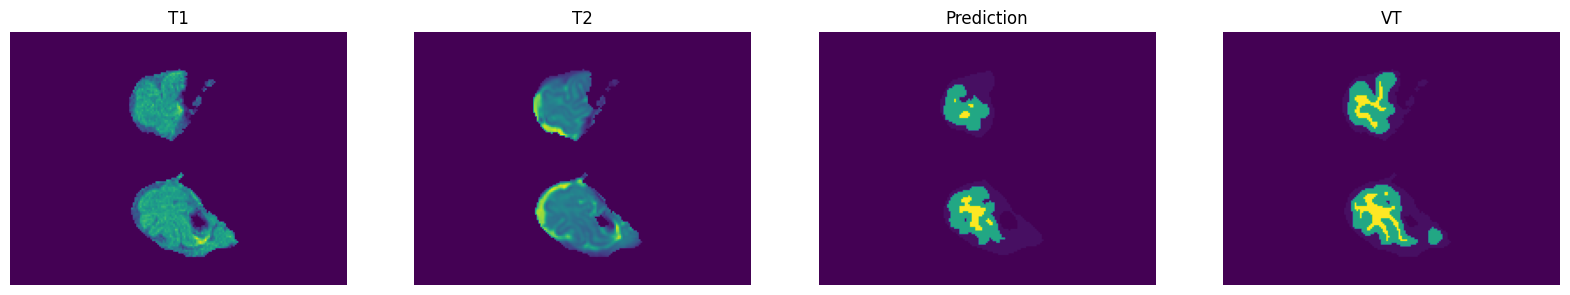

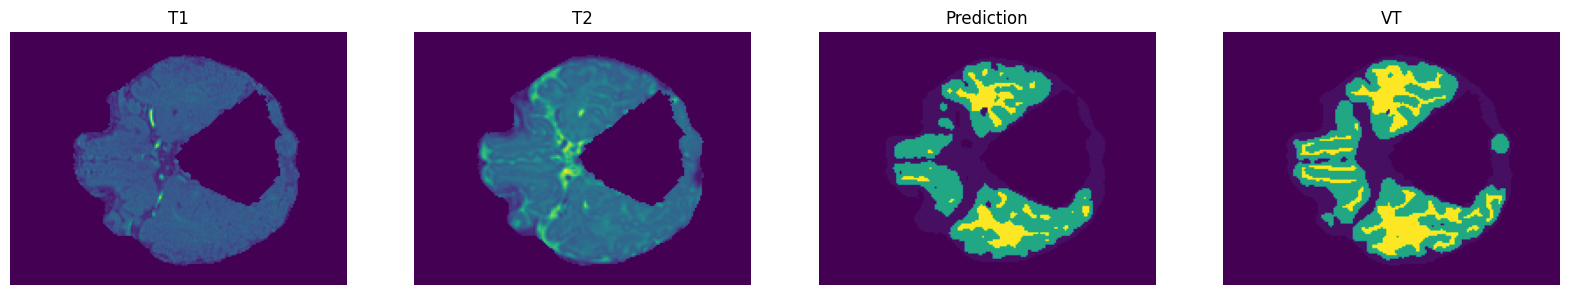

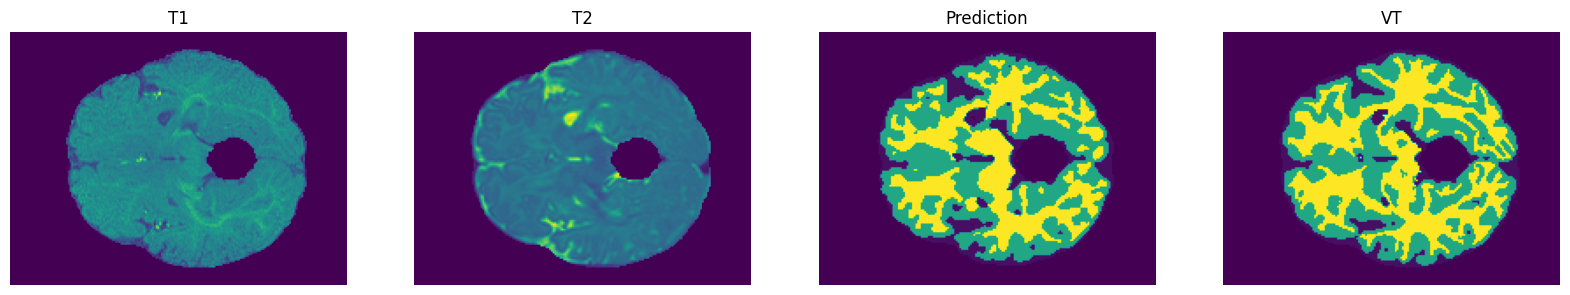

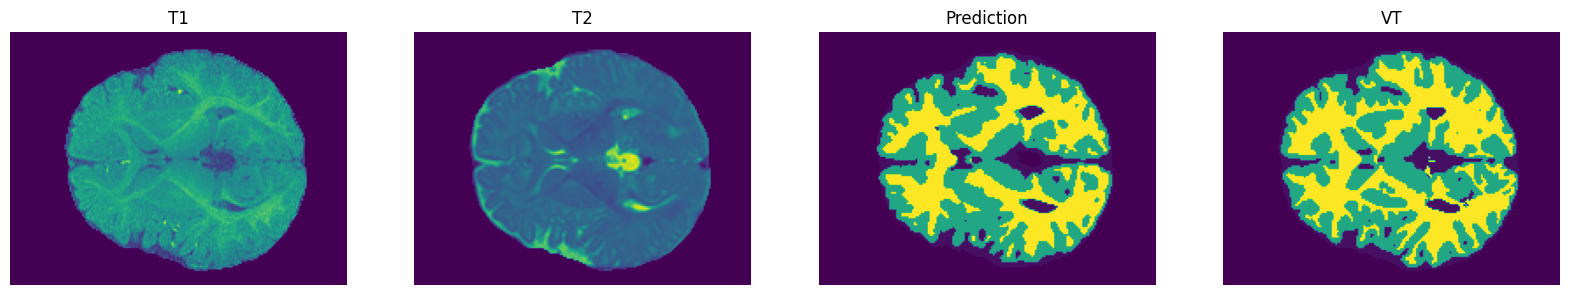

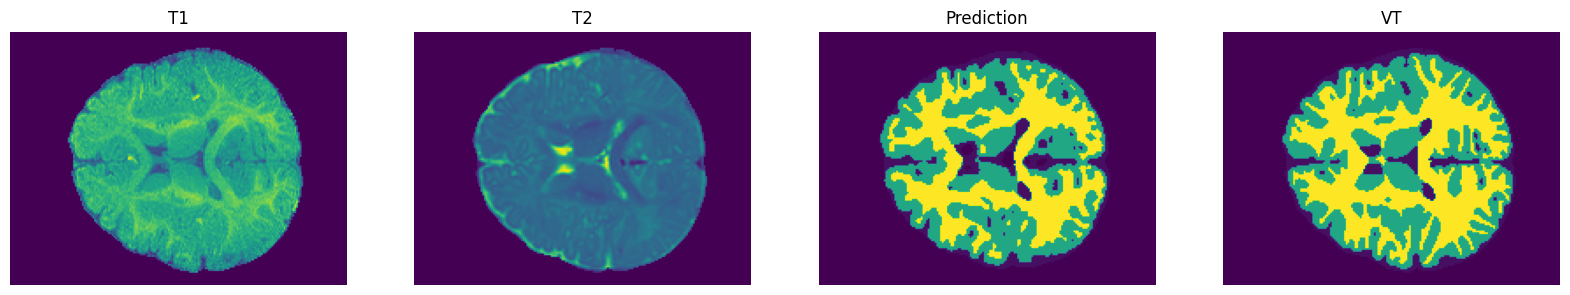

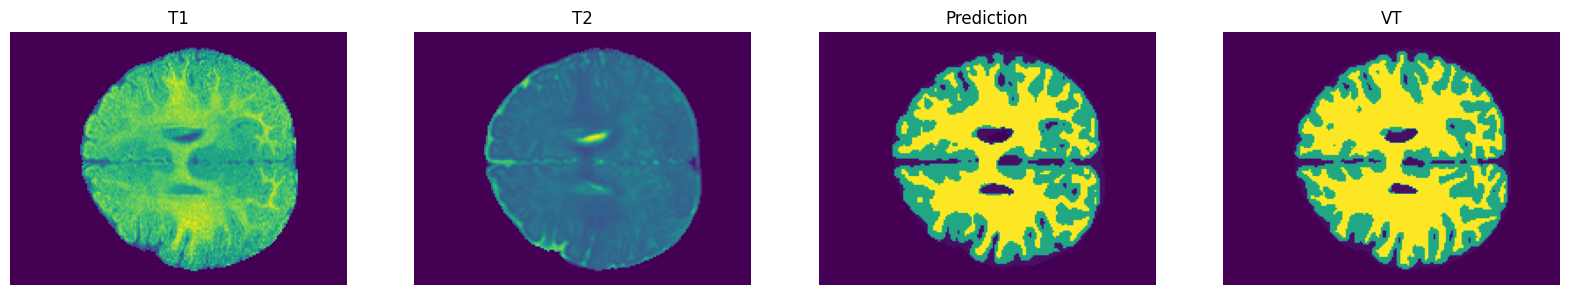

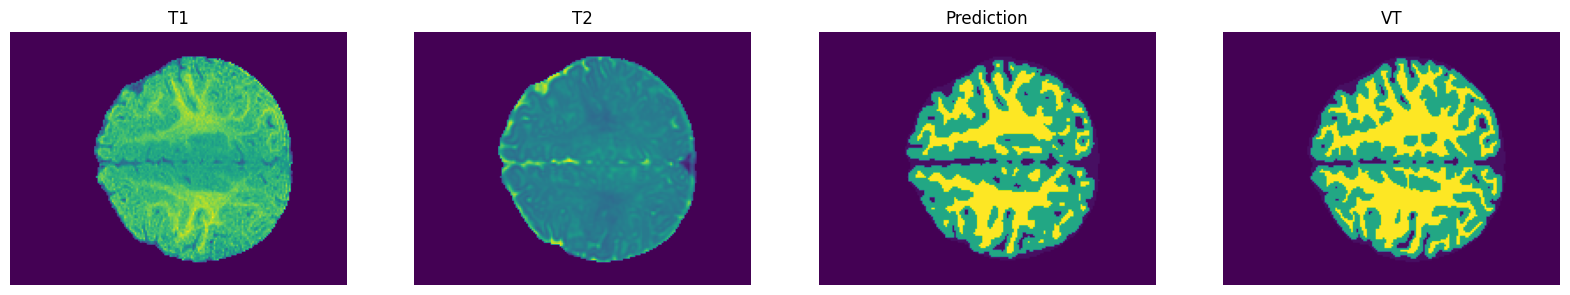

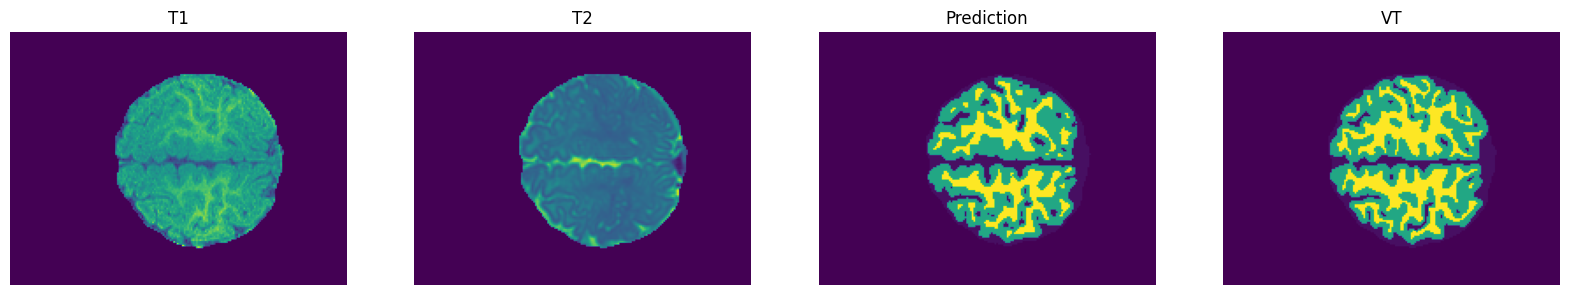

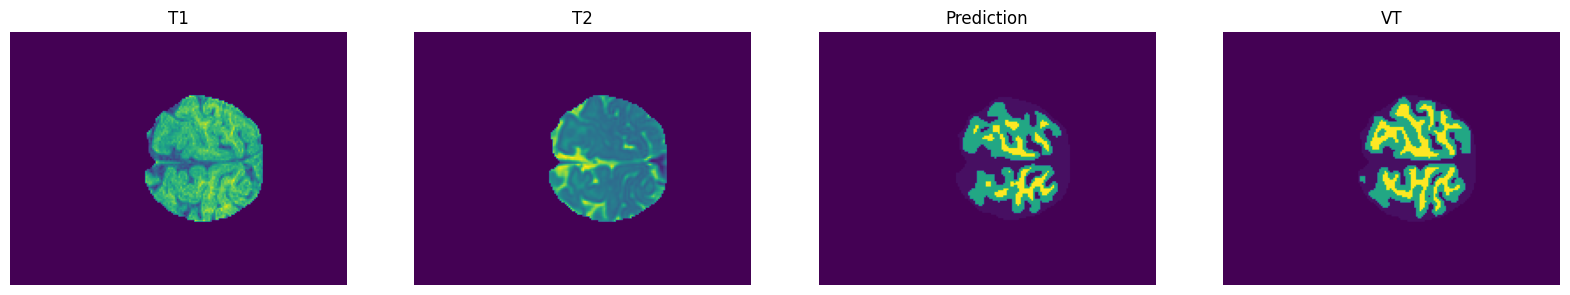

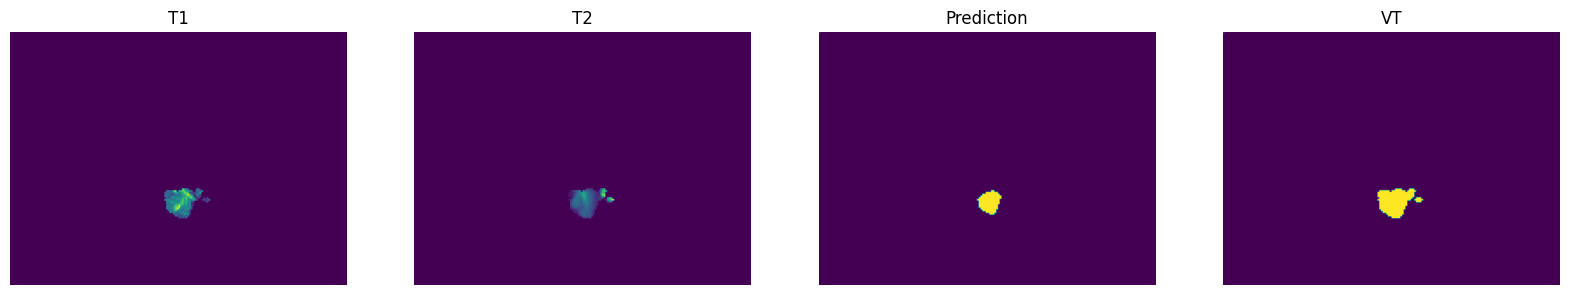

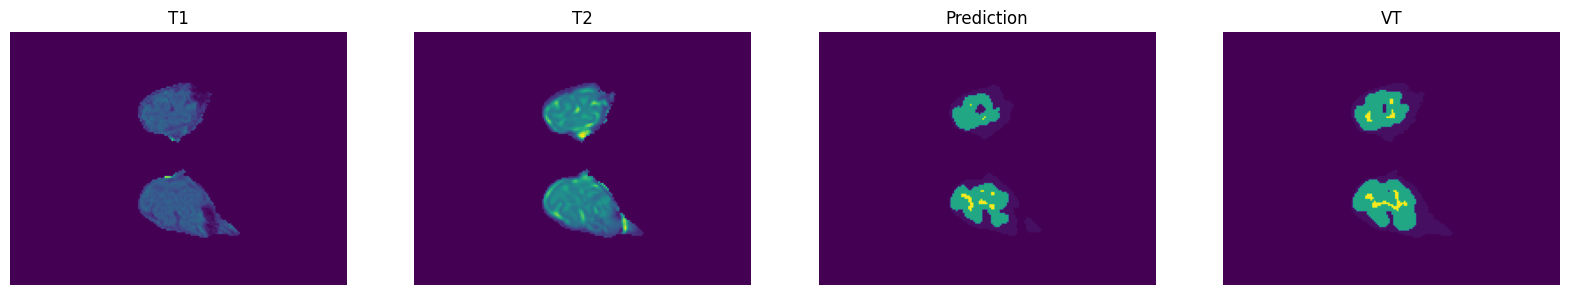

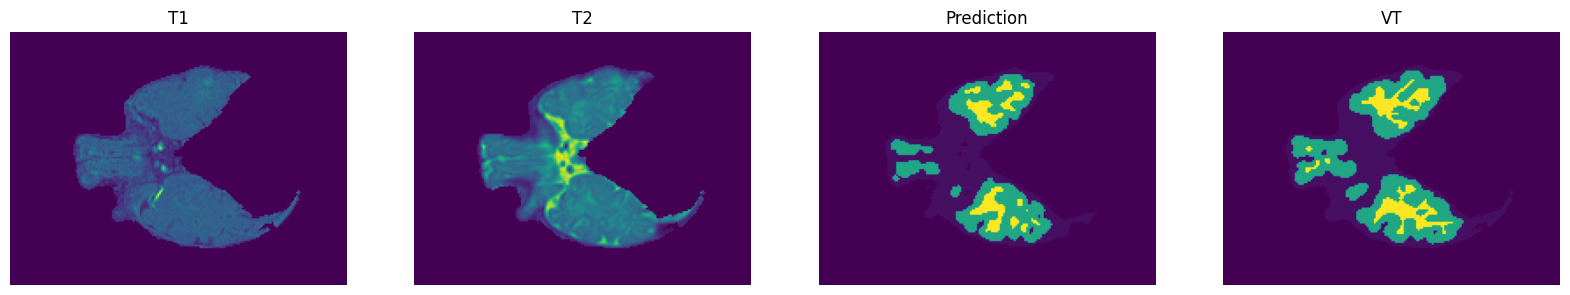

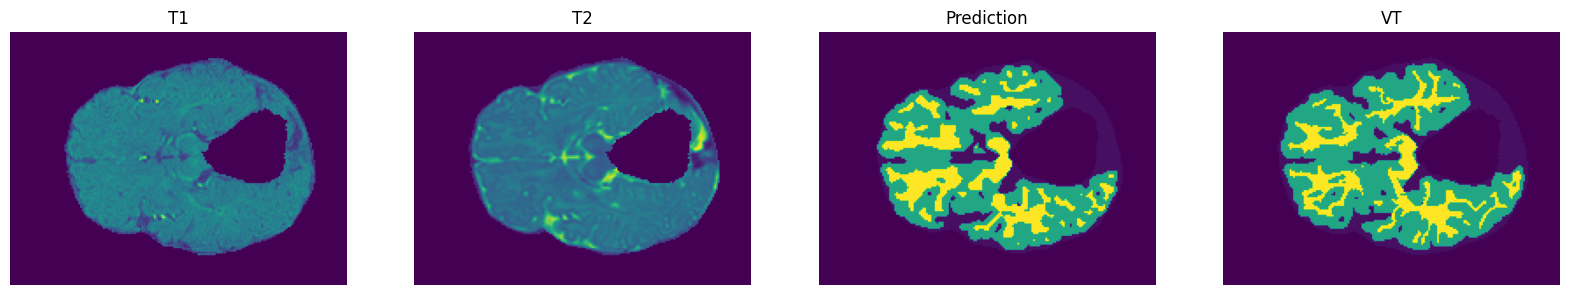

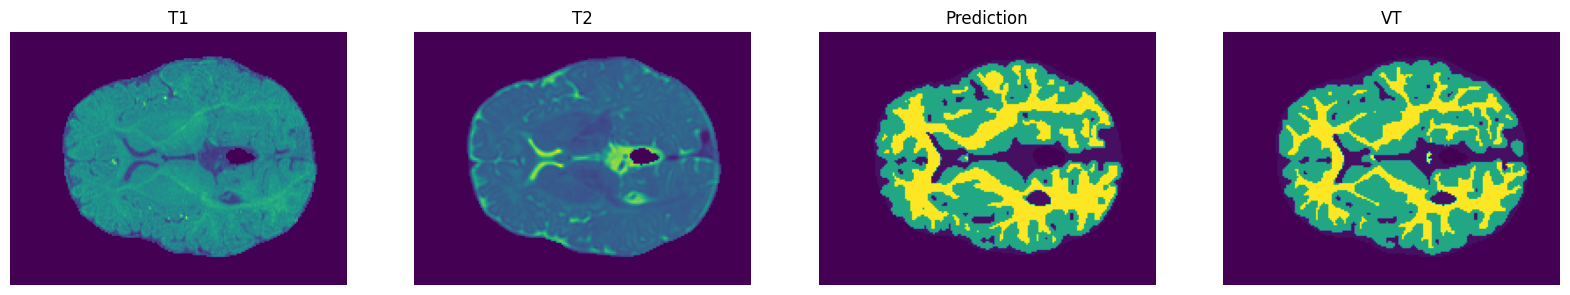

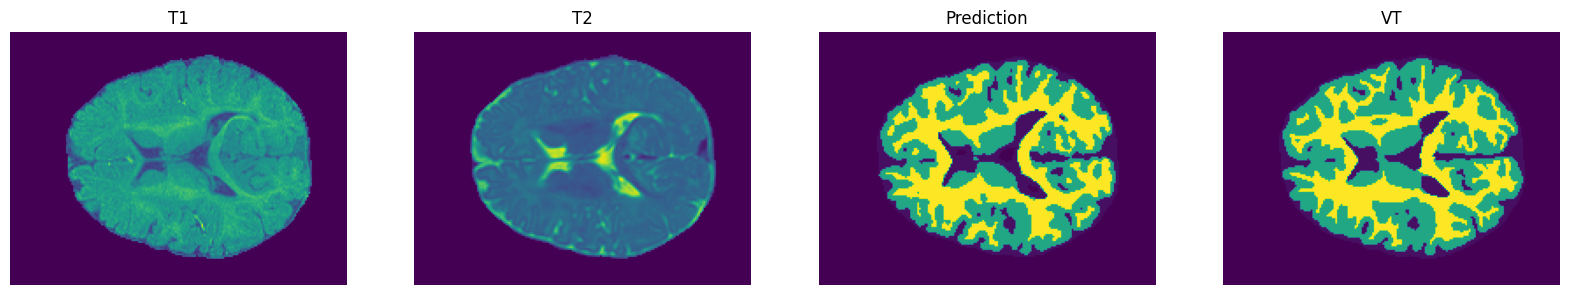

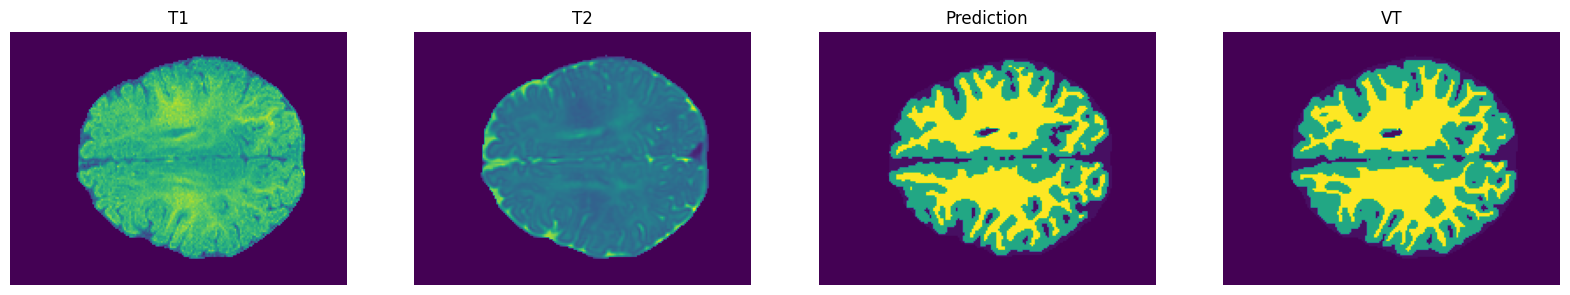

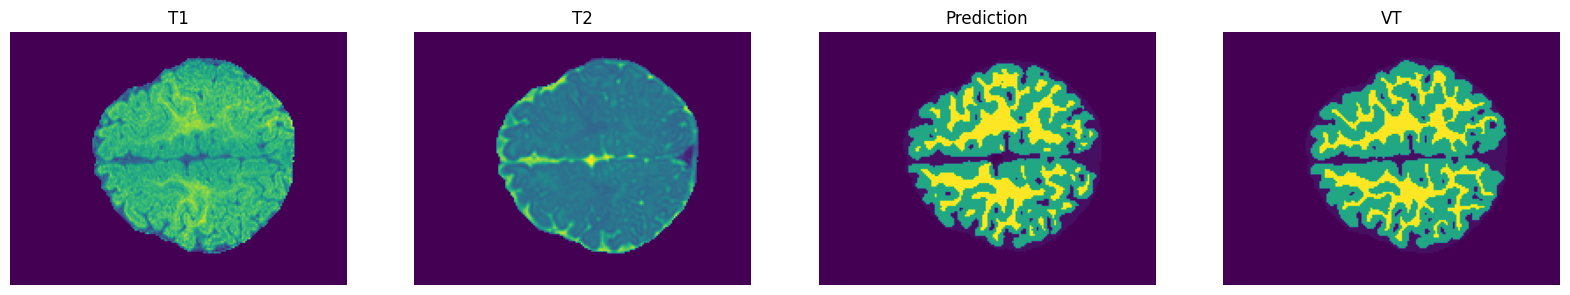

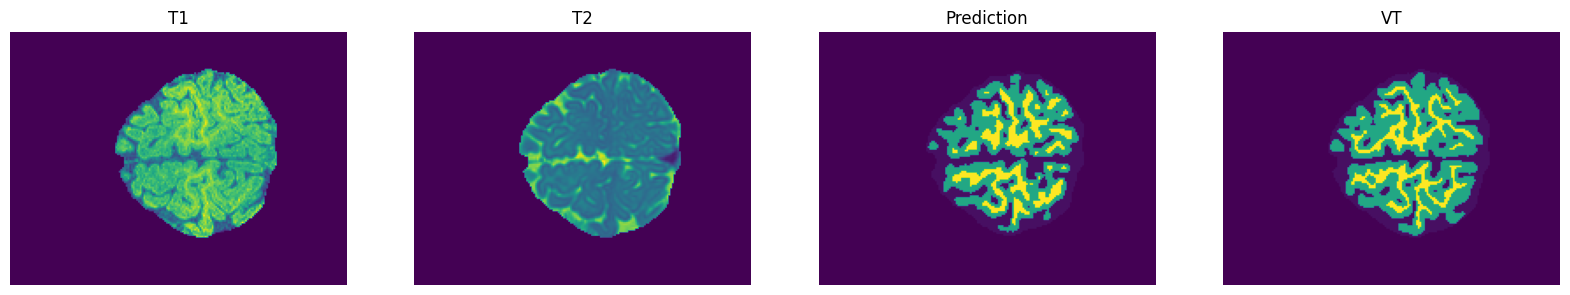

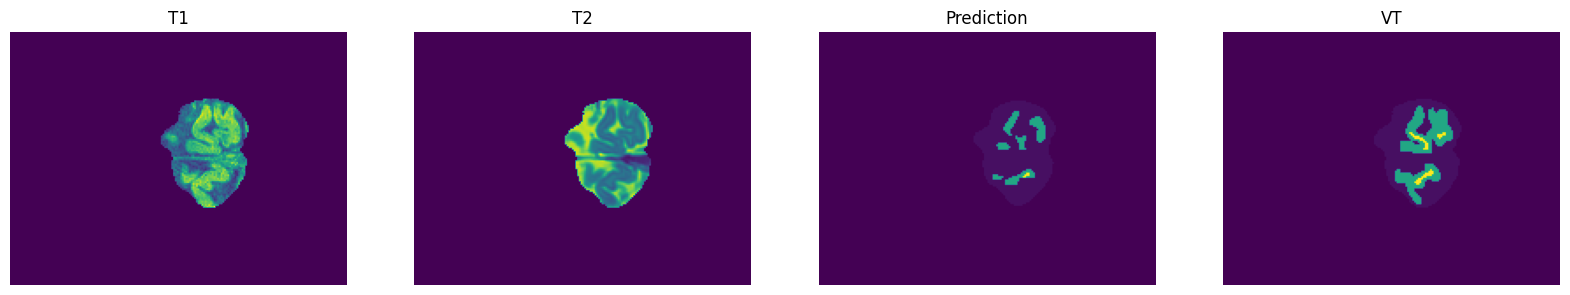

[0.8054242705470493, 0.7852589165472001]

In [ ]:
evaluate_network_step_3(test_patients)

In [ ]:
model.save_weights("unet_weights1.h5")
model2.save_weights("unet_weights2.h5")
model3.save_weights("unet_weights3.h5")